# Predictive Maintenance for Aircraft Turbofan Engines

The C-MAPSS dataset (Commercial Modular Aero-Propulsion System Simulation) is a widely used benchmark dataset for developing and evaluating predictive maintenance and Remaining Useful Life (RUL) prediction models for Aircraft Turbofan Engines. It was provided by NASA.

**Key Features of the Dataset**:

- Simulated Dataset:

It is generated using a high-fidelity engine simulator.
Simulates various operating conditions and fault modes.

- Purpose:

RUL estimation for engines based on sensor readings and operational settings.

- Sub-datasets:

Structure:

- Training Data: Full engine run-to-failure trajectories.
- Testing Data: Truncated trajectories (incomplete; ends before failure).
- Truth RUL File: Contains the actual RUL values for the engines in the test set.

Dataset Columns:
Each sub-dataset contains the following columns:

- Engine ID: Unique identifier for each engine.
- Time in Cycles: Time steps or cycles for an engine.
- Operational Settings (3 columns): Vary depending on operating conditions, e.g., altitude, throttle setting.
- Sensor Measurements (21 columns): Sensor readings capturing the engine's health metrics.

**Characteristics**:
- Train Dataset:

Each engine's trajectory ends at failure and contains the full operational history of engines.
RUL is calculated as:
RUL = max_cycle − current_cycle

- Test Dataset:

Each engine's trajectory is truncated and doesn't end in failure.
The provided RUL file specifies the actual remaining life from the last recorded cycle.
Typical Use Cases:
Training:

Train a regression model to predict RUL using sensor and operational data.
Use the train dataset where RUL is calculated.
Testing:

Evaluate model performance on the test dataset.
Predict RUL for engines and compare predictions to the truth values provided in the RUL file.



- Dataset Details:

Features: The dataset comprises multiple multivariate time series, each representing an engine's operational cycle from a healthy state to failure. It includes:

- Operational Settings: 3 operational settings that vary with each cycle.

- Sensor Measurements: 21 sensor measurements recorded for each cycle.

Structure: Each engine's data is presented as a sequence of operational cycles, capturing the degradation process leading to failure.

***The operational settings*** :

- altitudes ranging from sea level to 40,000 ft (operational settings 1 ), 
- mach numbers from 0 to 0.90 (operational settings 2) and 
- sea-level temperatures from –60 to 103 °F (operational settings 3)


***The sensor readings***:

- Sensor 1 (T2): Total temperature at the fan inlet.
- Sensor 2 (P2): Total pressure in the fan.
- Sensor 3 (T24): Total temperature at the Low Pressure  Compressor (LPC) outlet.
- Sensor 4 (T30): Total temperature at the High Pressure Compressor (HPC) outlet.
- Sensor 5 (T50): Total temperature at the Low Pressure Turbine (LPT) outlet.
- Sensor 6 (P15): Total pressure in the bypass duct.
- Sensor 7 (P30): Total pressure at the HPC outlet.
- Sensor 8 (Nf): Physical fan speed.
- Sensor 9 (Nc): Physical core speed.
- Sensor 10 (epr): Engine pressure ratio (P50/P2).
- Sensor 11 (Ps30): Static pressure at the HPC outlet.
- Sensor 12 (phi): Ratio of fuel flow to Ps30.
- Sensor 13 (NRf): Corrected fan speed.
- Sensor 14 (NRc): Corrected core speed.
- Sensor 15 (BPR): Bypass Ratio.
- Sensor 16 (htBleed): Bleed Enthalpy.
- Sensor 17 (W31): High-pressure turbine coolant bleed.
- Sensor 18 (W32): Low-pressure turbine coolant bleed.
- Sensor 19-21: Other proprietary or derived parameters related to engine performance.



In [68]:
#Import required libraries
import pandas as pd
import numpy as np
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_percentage_error,classification_report
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [69]:
#Loading the train and dataset

# Training data where the last cycle is the failure point for the engines
df_train= pd.read_csv(r'C:\Users\PC\OneDrive\Desktop\internship\CMPASS DATA\train_FD001.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
df_valid=pd.read_csv(r'C:\Users\PC\OneDrive\Desktop\internship\CMPASS DATA\test_FD001.txt', sep=" ", header=None)   

## Data Preprocessing

In [70]:
#Grouping the index ,settings and sensor data together

#Index Columns
index_names=['engine_id','time_in_cycles']

#Setting Columns
setting_names=['operational_setting_1','operational_setting_2','operational_setting_3']

#Constant sensor columns
drop_labels=['s1', 's5','s6','s10',  's16', 's18', 's19']

#Sensor columns
sensor_names = [f's{i}' for i in range(1, 22)]

#Sensor columns after removal of constant sensors
updated_sensor_names=[f's{i}' for i in range(1, 22) if f's{i}' not in drop_labels]

In [71]:
#Visualization of train dataset
df_train.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

In [72]:
#Visualization of validation dataset
df_valid.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735 NaN NaN  
1  ...  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916 NaN NaN  
2  ...  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166 NaN NaN  
3  ...  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737 NaN NaN  
4  ...  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130 NaN NaN  

[5 rows x 28 columns]

In [73]:
#Handling the missing values for  both train and test data
df_train.dropna(axis=1, how='all', inplace=True)
df_valid.dropna(axis=1, how='all', inplace=True)

Adding the column names based on given information in orginal paper , Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation 

In [74]:
#Assigning the column names
col_names = ['engine_id', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f's{i}' for i in range(1, 22)]
df_train.columns = col_names
df_valid.columns = col_names
df_train.head()

engine_id  time_in_cycles  operational_setting_1  operational_setting_2  \
0          1               1                -0.0007                -0.0004   
1          1               2                 0.0019                -0.0003   
2          1               3                -0.0043                 0.0003   
3          1               4                 0.0007                 0.0000   
4          1               5                -0.0019                -0.0002   

   operational_setting_3      s1      s2       s3       s4     s5  ...  \
0                  100.0  518.67  641.82  1589.70  1400.60  14.62  ...   
1                  100.0  518.67  642.15  1591.82  1403.14  14.62  ...   
2                  100.0  518.67  642.35  1587.99  1404.20  14.62  ...   
3                  100.0  518.67  642.35  1582.79  1401.87  14.62  ...   
4                  100.0  518.67  642.37  1582.85  1406.22  14.62  ...   

      s12      s13      s14     s15   s16  s17   s18    s19    s20      s21  
0  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190  
1  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236  
2  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442  
3  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739  
4  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

In [75]:
#Sort the data set by id and cycles
df_train.sort_values(['engine_id', 'time_in_cycles'], inplace=True)
df_valid.sort_values(['engine_id', 'time_in_cycles'], inplace=True)

Add a column for the remaining useful life (RUL) of each engine in the training set. 
- Each engine runs until failure.
- The last recorded cycle for each engine is the point of failure.

In [76]:
#Calculating the Remaining Useful Life (RUL) for train dataset
rul=pd.DataFrame(df_train.groupby('engine_id')['time_in_cycles'].max()).reset_index()
rul.columns = ['engine_id', 'max']
df_train = df_train.merge(rul, on=['engine_id'], how='left')
df_train['RUL'] = df_train['max'] - df_train['time_in_cycles']
df_train[['engine_id','time_in_cycles','max','RUL']].head()

engine_id  time_in_cycles  max  RUL
0          1               1  192  191
1          1               2  192  190
2          1               3  192  189
3          1               4  192  188
4          1               5  192  187

The max column can be dropped, because it is maximum remaining useful life (RUL) for each engine

In [77]:
df_train.drop('max', axis=1, inplace=True)

In the test dataset, engines are monitored only up to a certain point, and they do not run until failure. Instead:
We are given the additional RUL for each engine as ground truth (df_truth['additional_rul']).

In [78]:
#Loading the ground truth file
y_valid=pd.read_csv(r'C:\Users\PC\OneDrive\Desktop\internship\CMPASS DATA\RUL_FD001.txt', sep=" ", header=None)

In [79]:
#Adding the column names to the ground truth file
y_valid=y_valid.drop(columns=[1])

In [80]:
#Adding the column names to the ground truth file
y_valid.columns = ['RUL']
y_valid['engine_id'] = y_valid.index + 1
y_valid

RUL  engine_id
0   112          1
1    98          2
2    69          3
3    82          4
4    91          5
..  ...        ...
95  137         96
96   82         97
97   59         98
98  117         99
99   20        100

[100 rows x 2 columns]

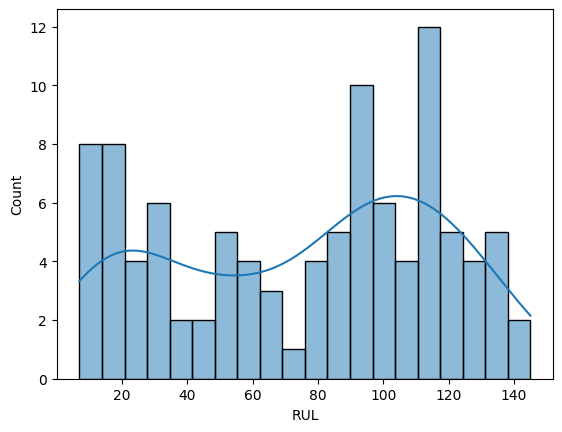

In [81]:
#Visualization of RUL values distribution for train dataset
plt.figure()
sns.histplot(y_valid["RUL"], kde=True, bins=20)
plt.show()

In [82]:
#Saving the dataset for further feature scaling
df_train_fe=df_train.copy()
df_valid_fe=df_valid.copy()

In [83]:
df_train_eda=df_train.copy()
df_valid_eda=df_train.copy()

# Feature Scaling

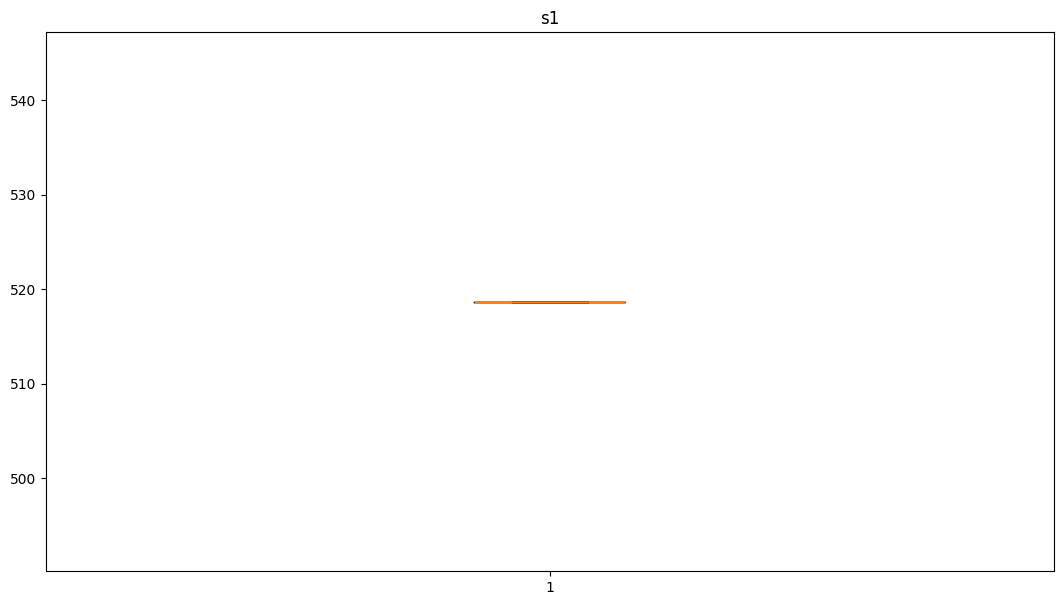

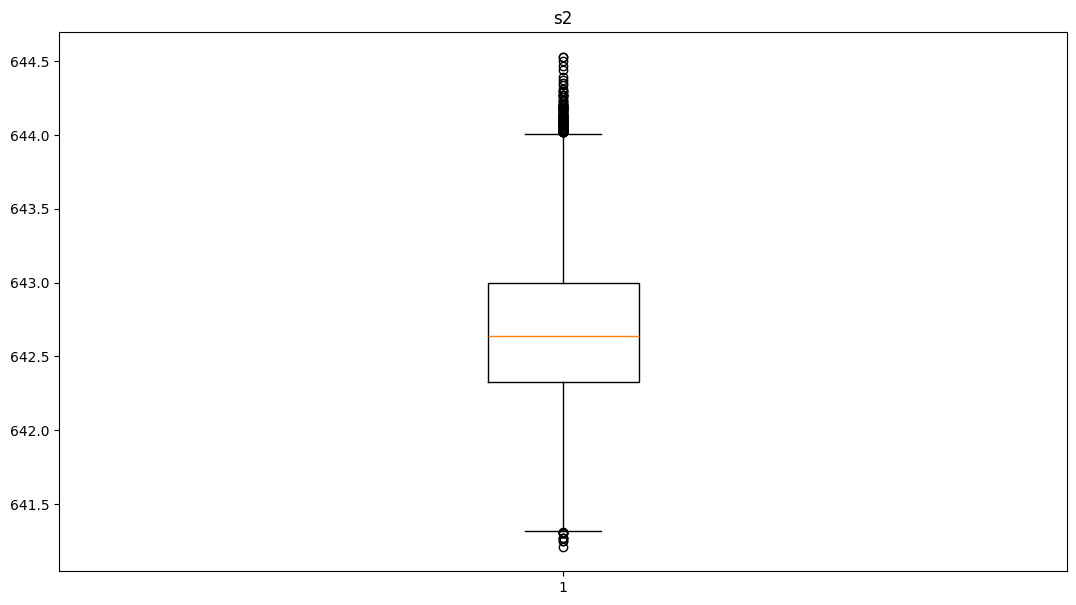

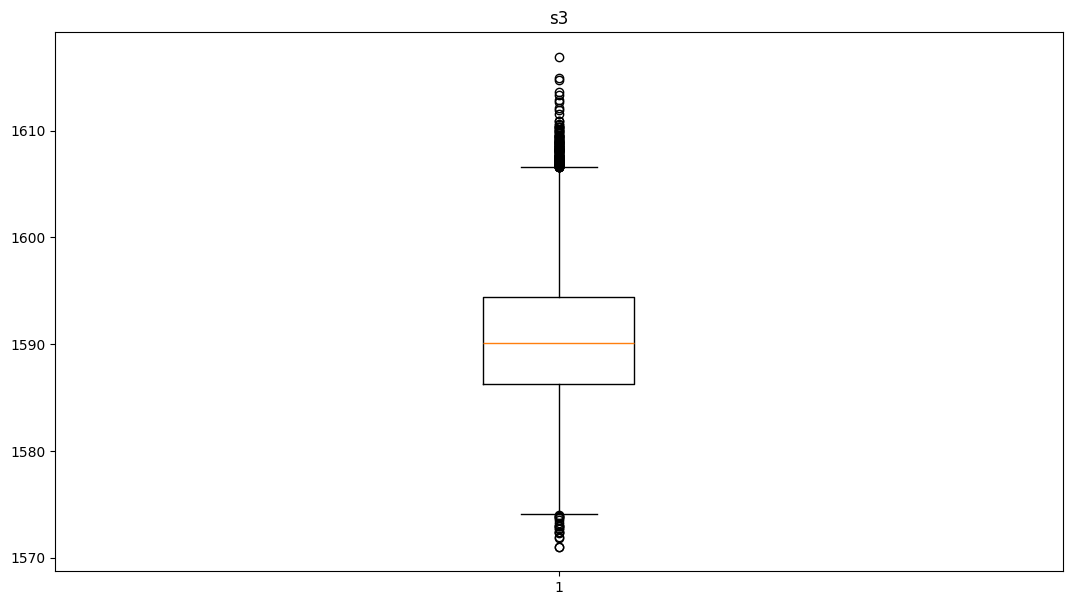

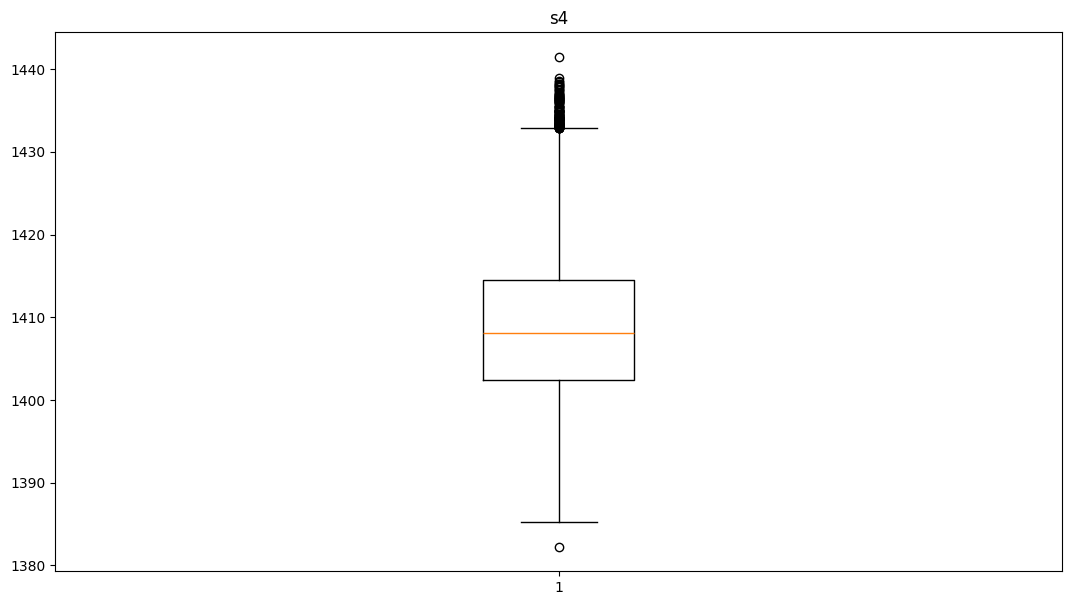

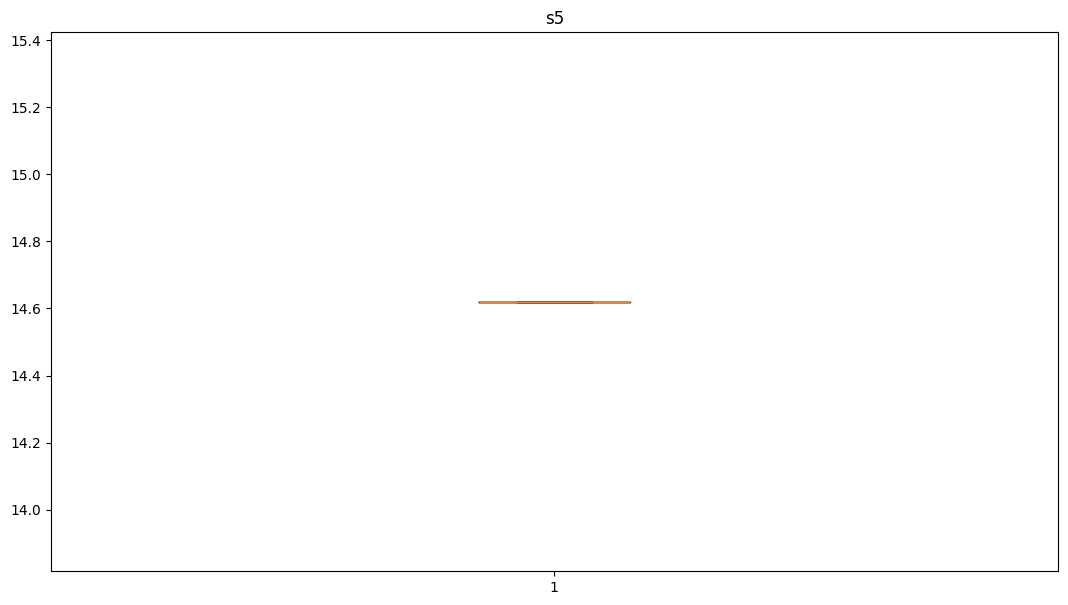

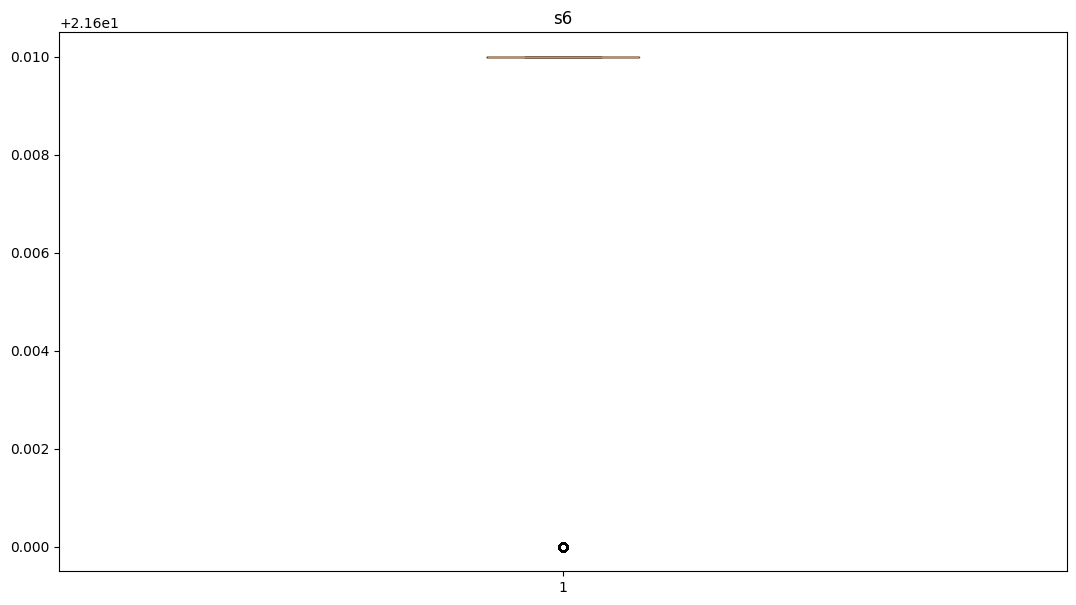

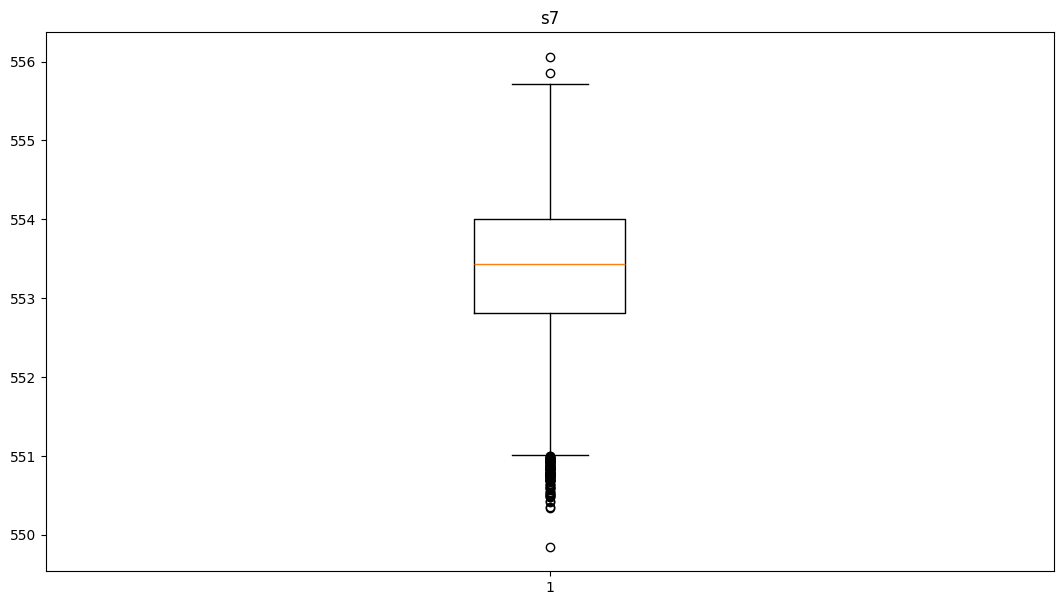

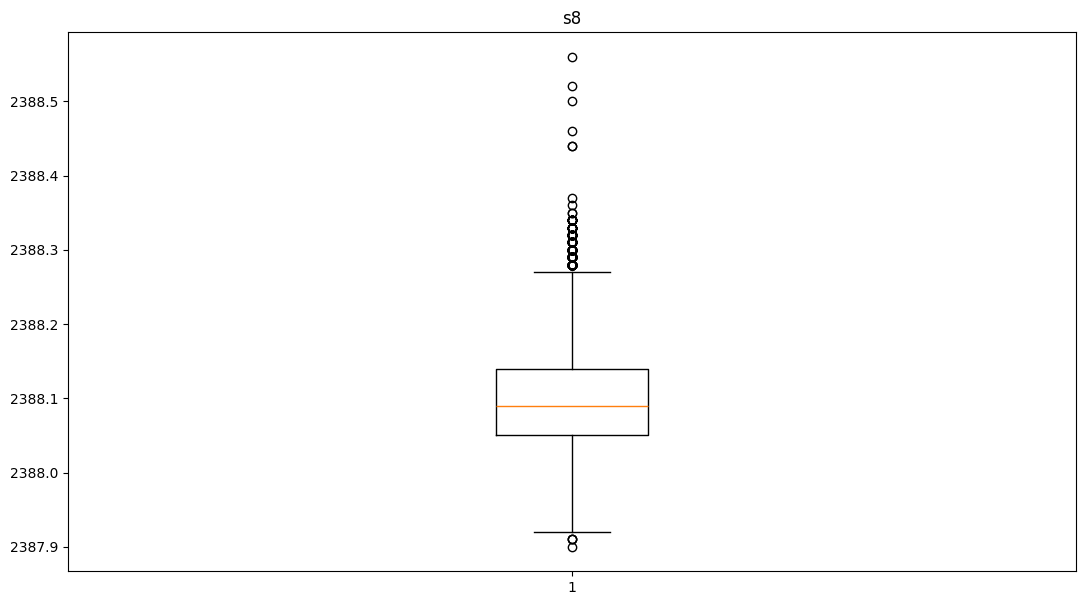

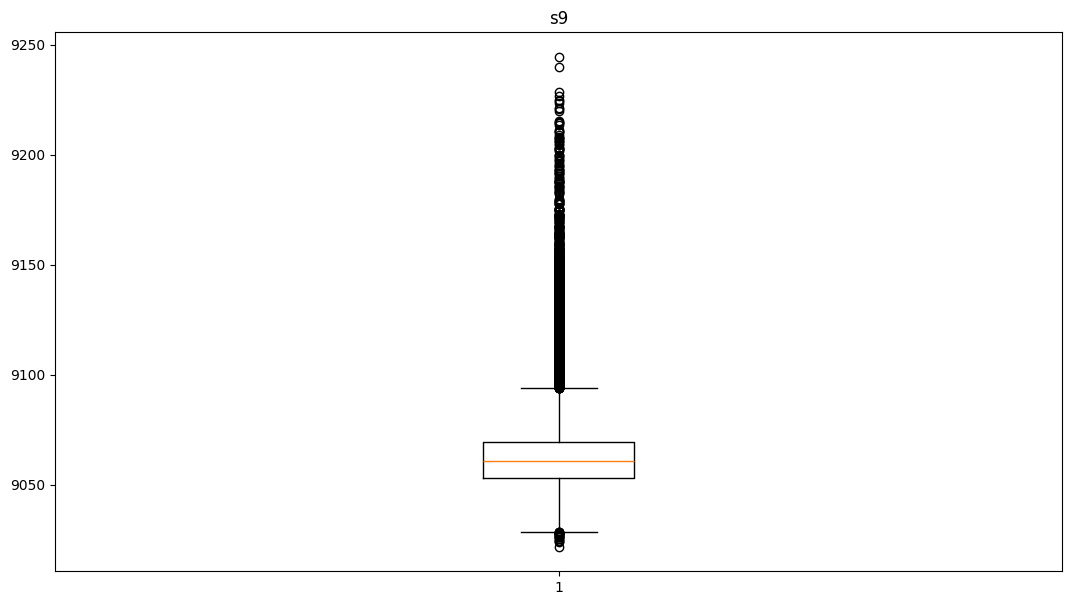

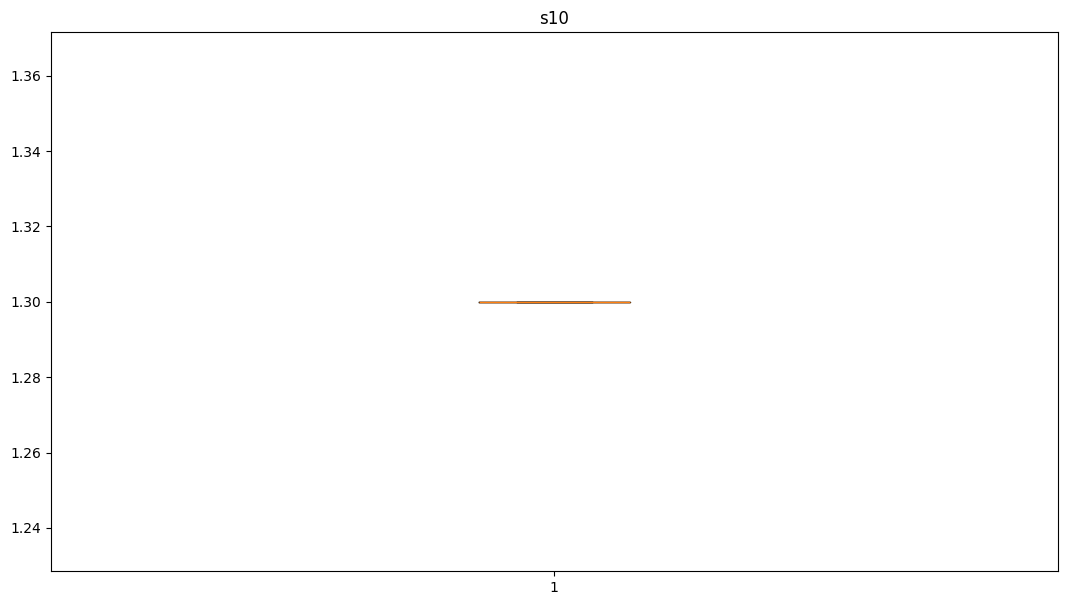

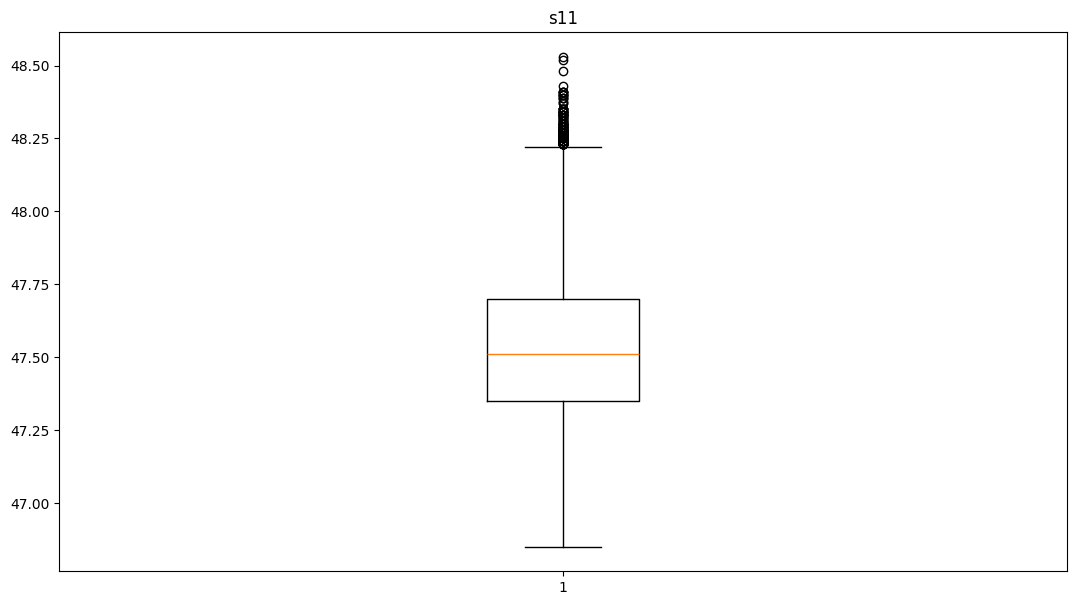

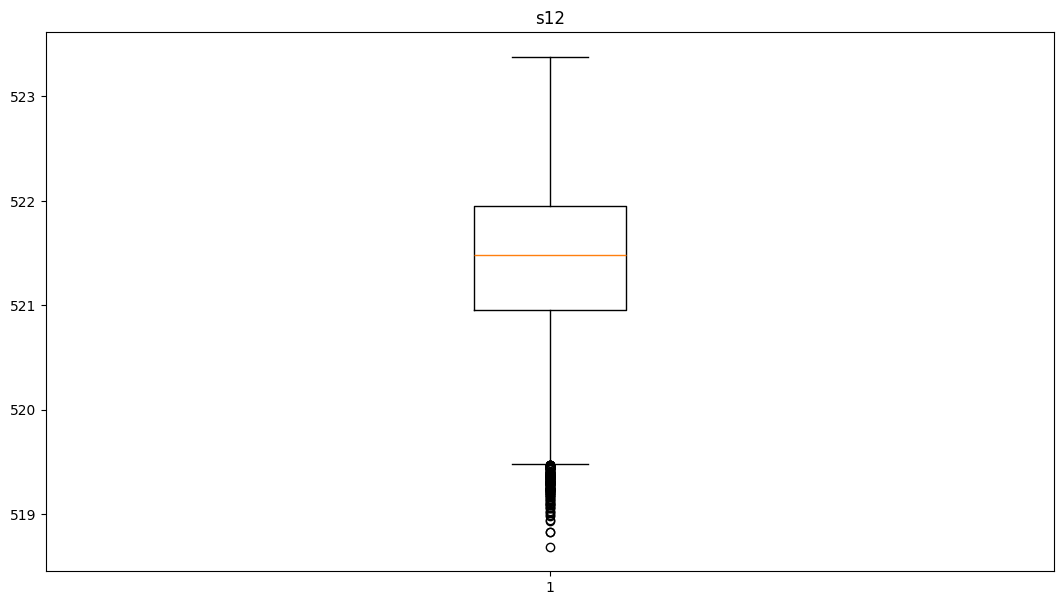

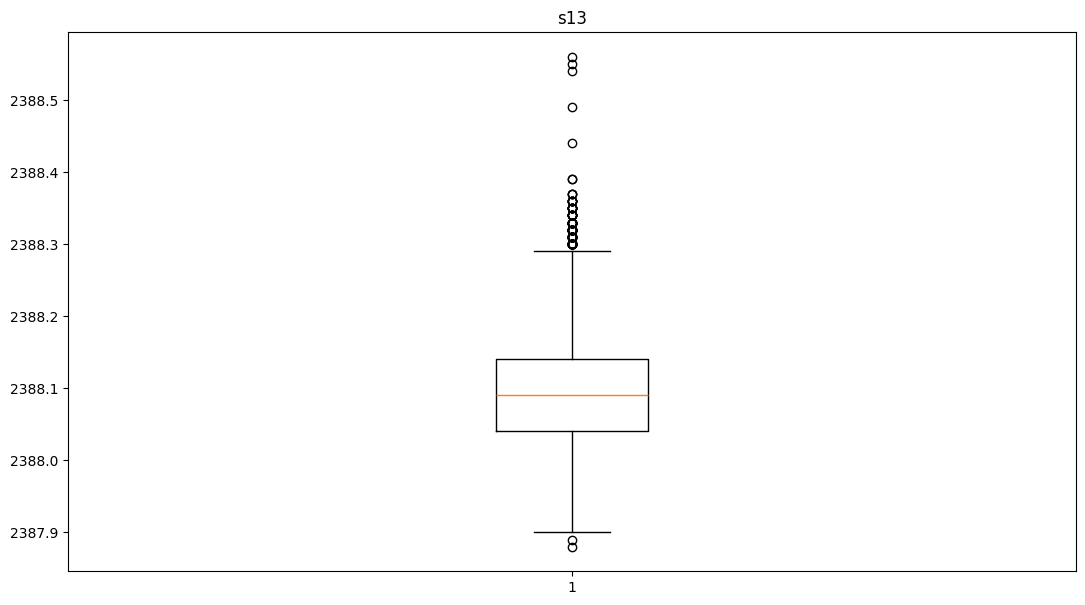

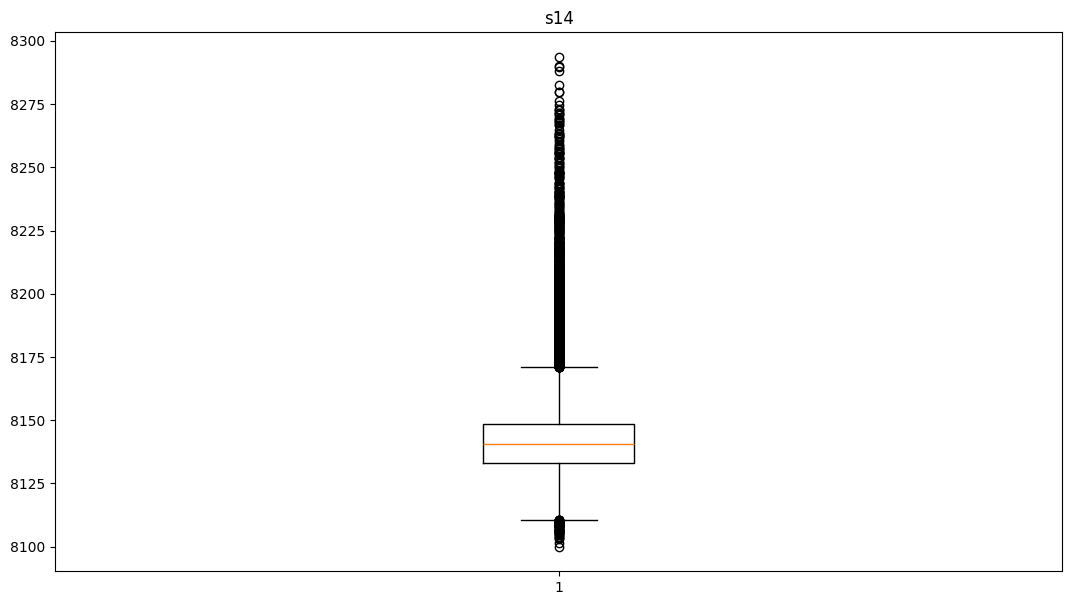

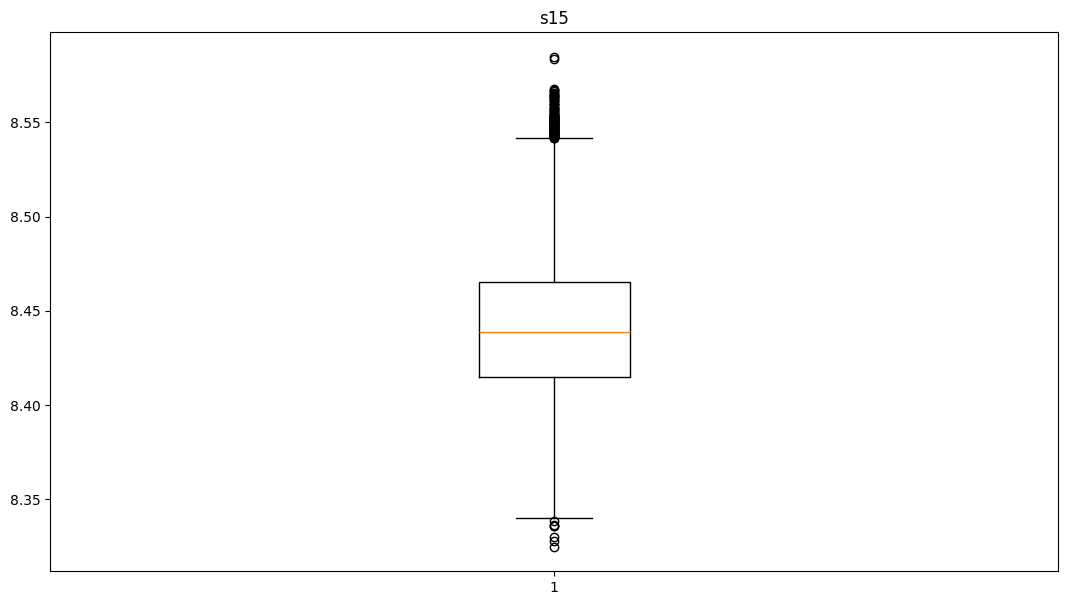

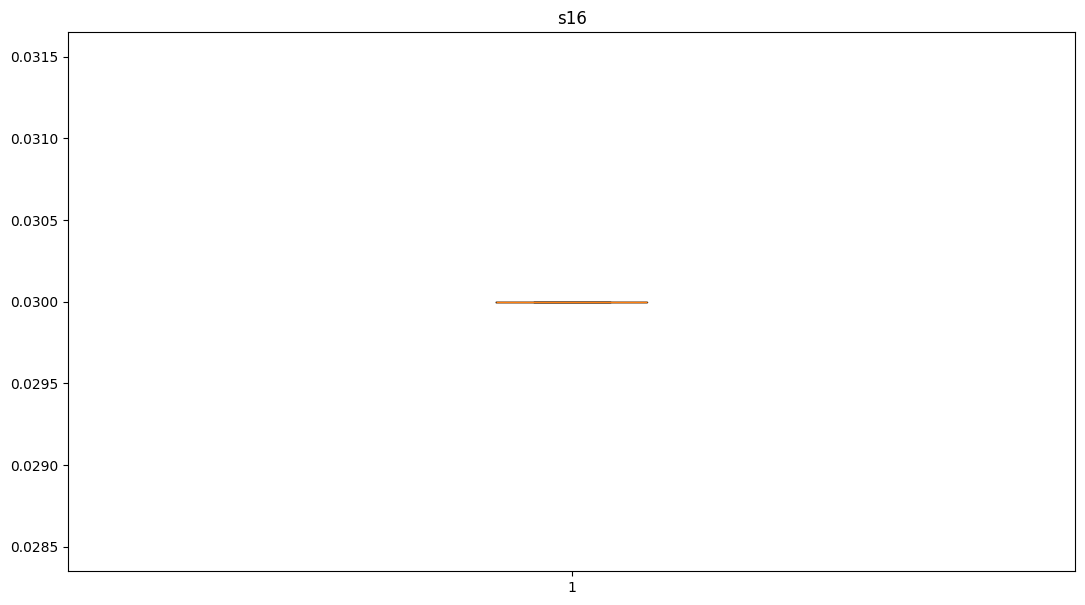

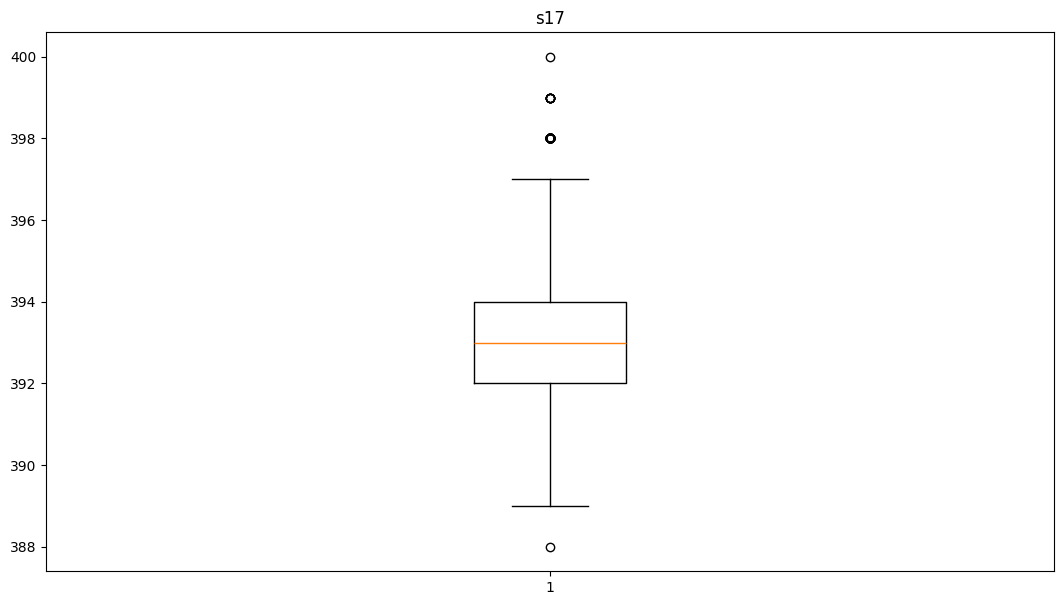

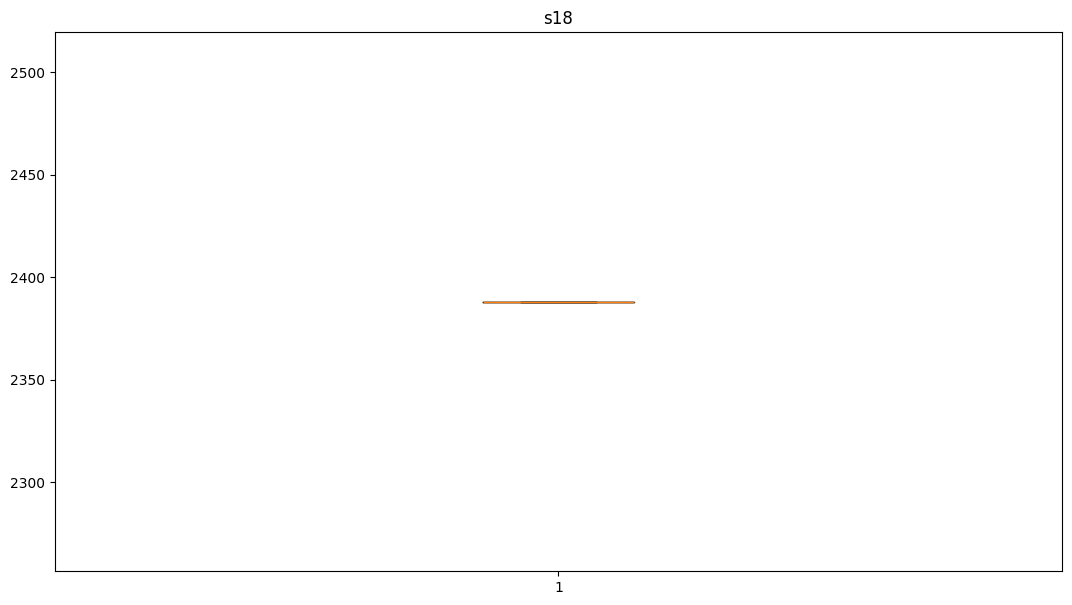

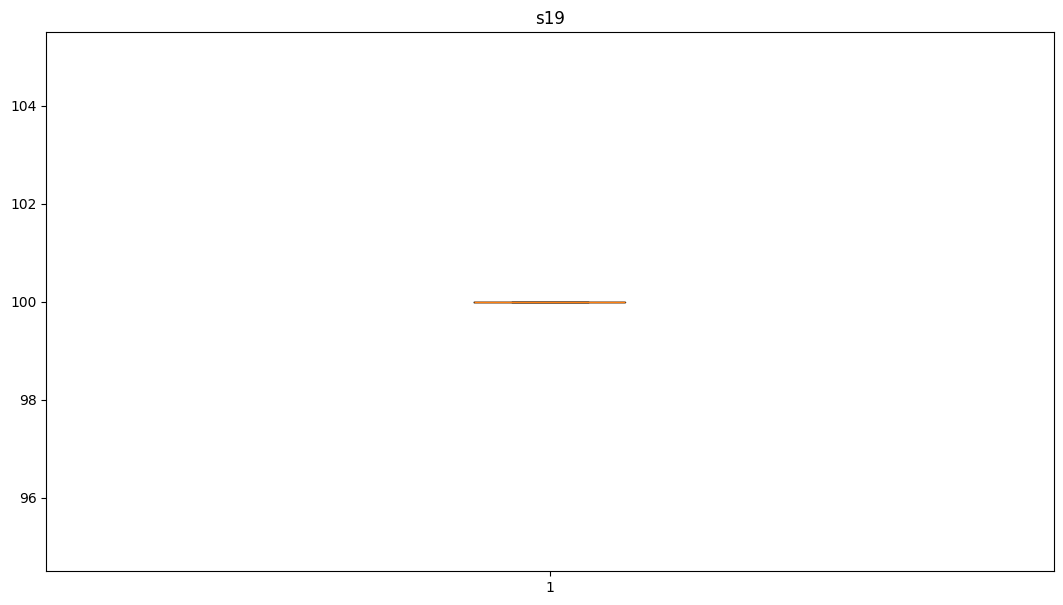

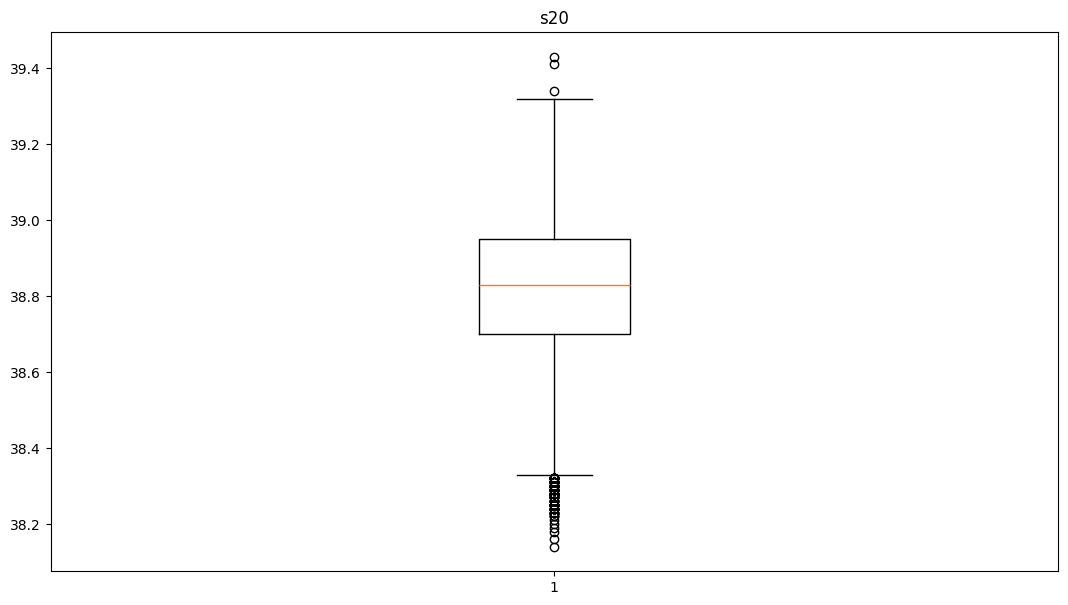

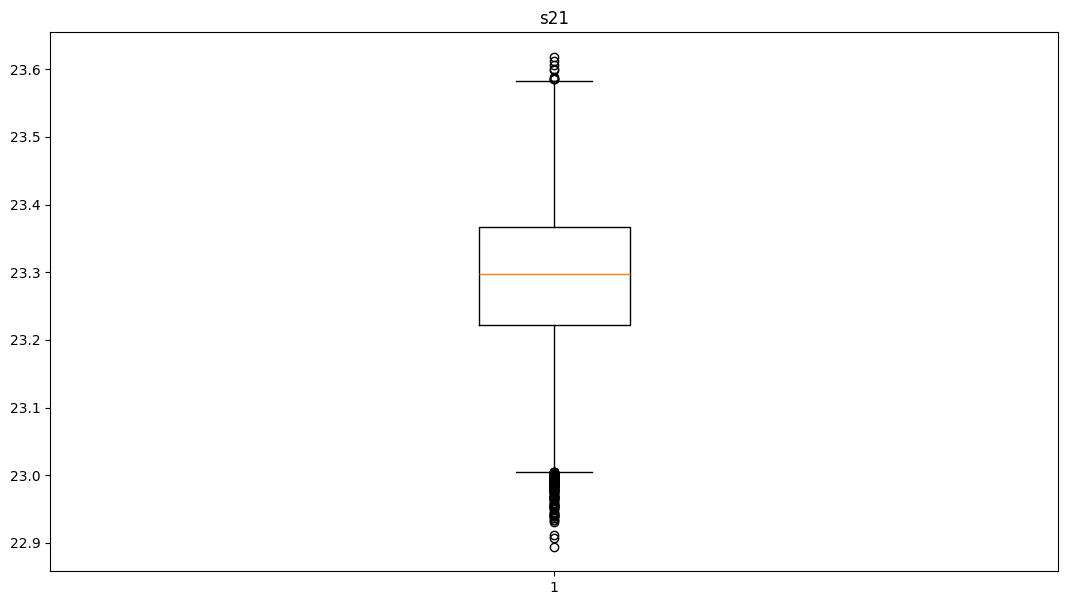

In [84]:
#Normalization of sensor reading columns(s1,s2,s3)
sensor_names = ['s{}'.format(i+1) for i in range(0,21)]
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(df_train_fe[x])
    plt.title(x)
    plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensor readings aren't well distributed and there are many outliers, then we should scale our data.The sensor with constant values will be added to list as :

In [85]:
#Normalization of the sensor values and the removal of constant sensors
cols_normalize = df_train_fe.columns.drop(index_names+setting_names+ ['RUL'])
print(cols_normalize)

min_max_scaler = MinMaxScaler()
norm_df_train = pd.DataFrame(min_max_scaler.fit_transform(df_train_fe[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_train_fe.index)
                          

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')


In [86]:
#Adding the index columns (engine id and cycles) and RUL to the normalized data
df_join = df_train_fe[index_names+['RUL']].join(norm_df_train)
df_train_fe = df_join.reindex(columns=index_names + ['RUL'] + list(cols_normalize))

In [87]:
#Normalization of the sensor values of  validation dataset and the removal of constant sensors
cols_normalize_v = df_valid_fe.columns.drop(index_names+setting_names)
scaler = MinMaxScaler()
norm_df_valid = pd.DataFrame(scaler.fit_transform(df_valid_fe[cols_normalize_v]), 
                             columns=cols_normalize_v, 
                             index=df_valid.index)

join_df_valid = df_valid_fe[index_names].join(norm_df_valid)
df_valid_fe = join_df_valid.reindex(columns=index_names + list(cols_normalize_v))


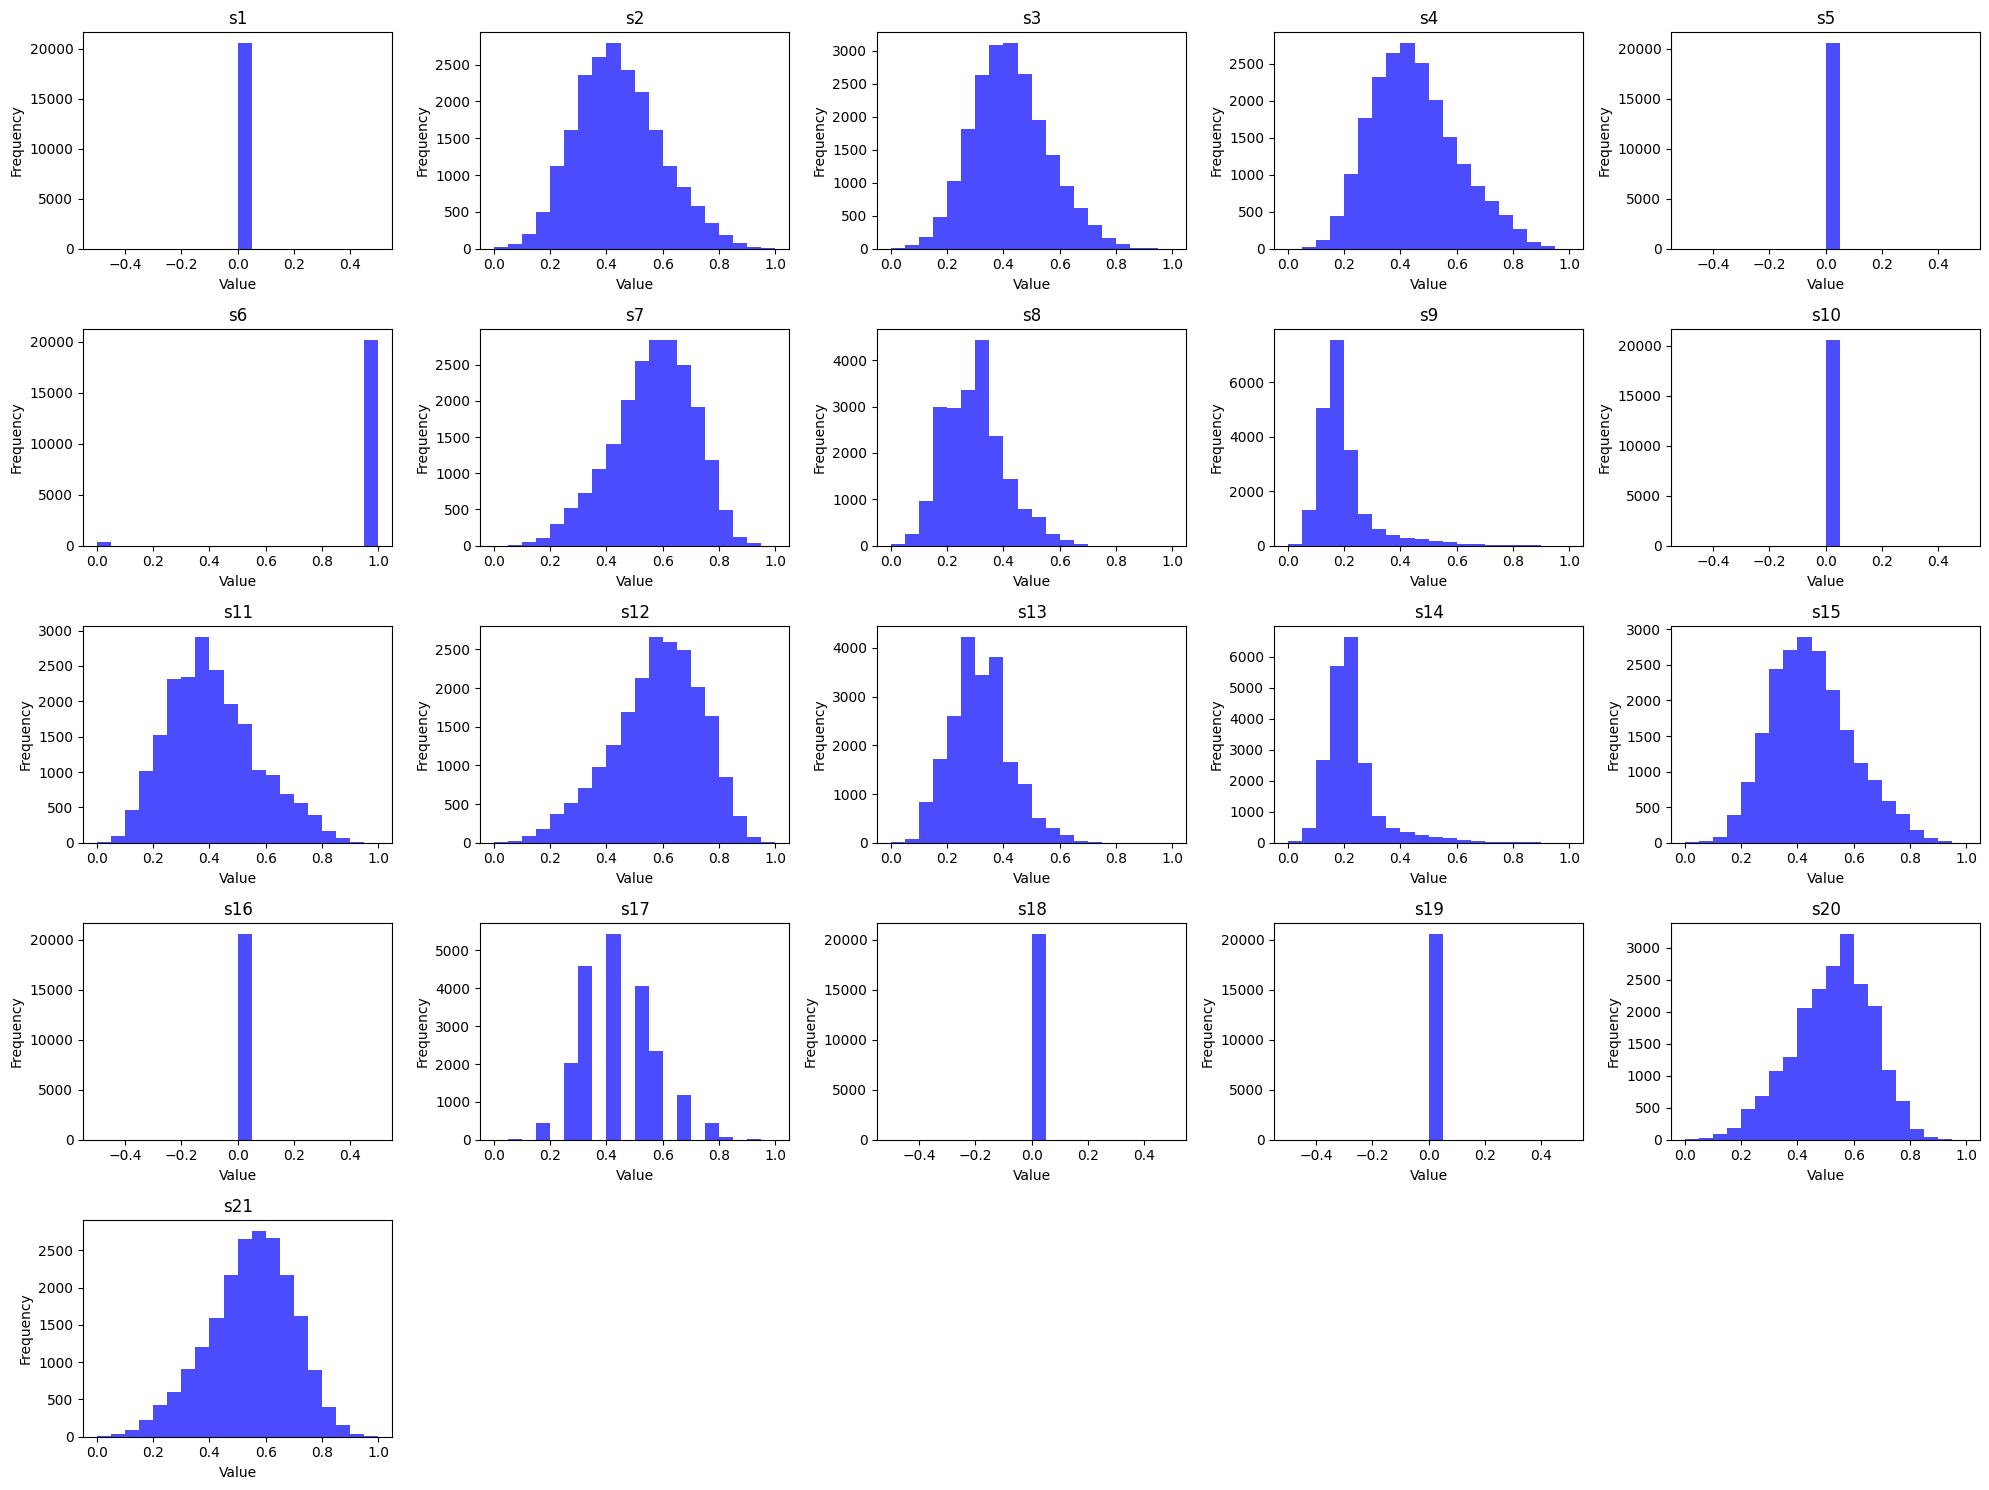

In [88]:
#Visualization of sensor distribution after the normalization
plt.figure(figsize=(20, 15))
for i, sensor in enumerate(sensor_names):
    plt.subplot(5, 5, i + 1) 
    plt.hist(df_train_fe[sensor], bins=20, color='blue', alpha=0.7)
    plt.title(sensor)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
plt.show()


After min-max normalization, the histograms of each sensor reading values have been plotted.As we can see, after normalization step the values are normally distributed around mean value,which is good sign of uniformity among each feature

In [89]:
#Saving the dataset with normalized sensor columns and RUL values
df_train_fe_dc=df_train_fe.drop(columns=drop_labels)
df_valid_fe_dc=df_valid_fe.drop(columns=drop_labels) 

# Feature Optimization

### Second way of normalization

In [90]:
#Function for the normalization by n-values
def normalize_by_first_n_values(df, grp_col, features=None, rolling=1):
    start_value = df.groupby(grp_col).transform(lambda x: x.iloc[:rolling].mean())  
    if features:
        df[features] = df[features] / start_value[features]
    else:
        df = df / start_value

    return df


In [91]:
#  Normalization by first n-values
df_train_fe_nr_n=normalize_by_first_n_values(df_train, 'engine_id', sensor_names , 10)  
df_valid_fe_nr_n=normalize_by_first_n_values(df_valid, 'engine_id', sensor_names , 10)

In [92]:
#Calculating the clipping threshold
max_time_cycles = df_train.groupby("engine_id")["time_in_cycles"].max()
failure_time=max_time_cycles.reset_index()
min_failure_time = int(failure_time["time_in_cycles"].min()*0.95)
min_failure_time

121

In [93]:
#Clipping the RUL values above the certain threshold
import pandas as pd

def clipping(df, col, value):

    df[col] = df[col].clip(upper=value)

    return df

## Explatory Data Analysis

In this step, we aim to visualize the operational lifespan of each turbofan engine in the train dataset.

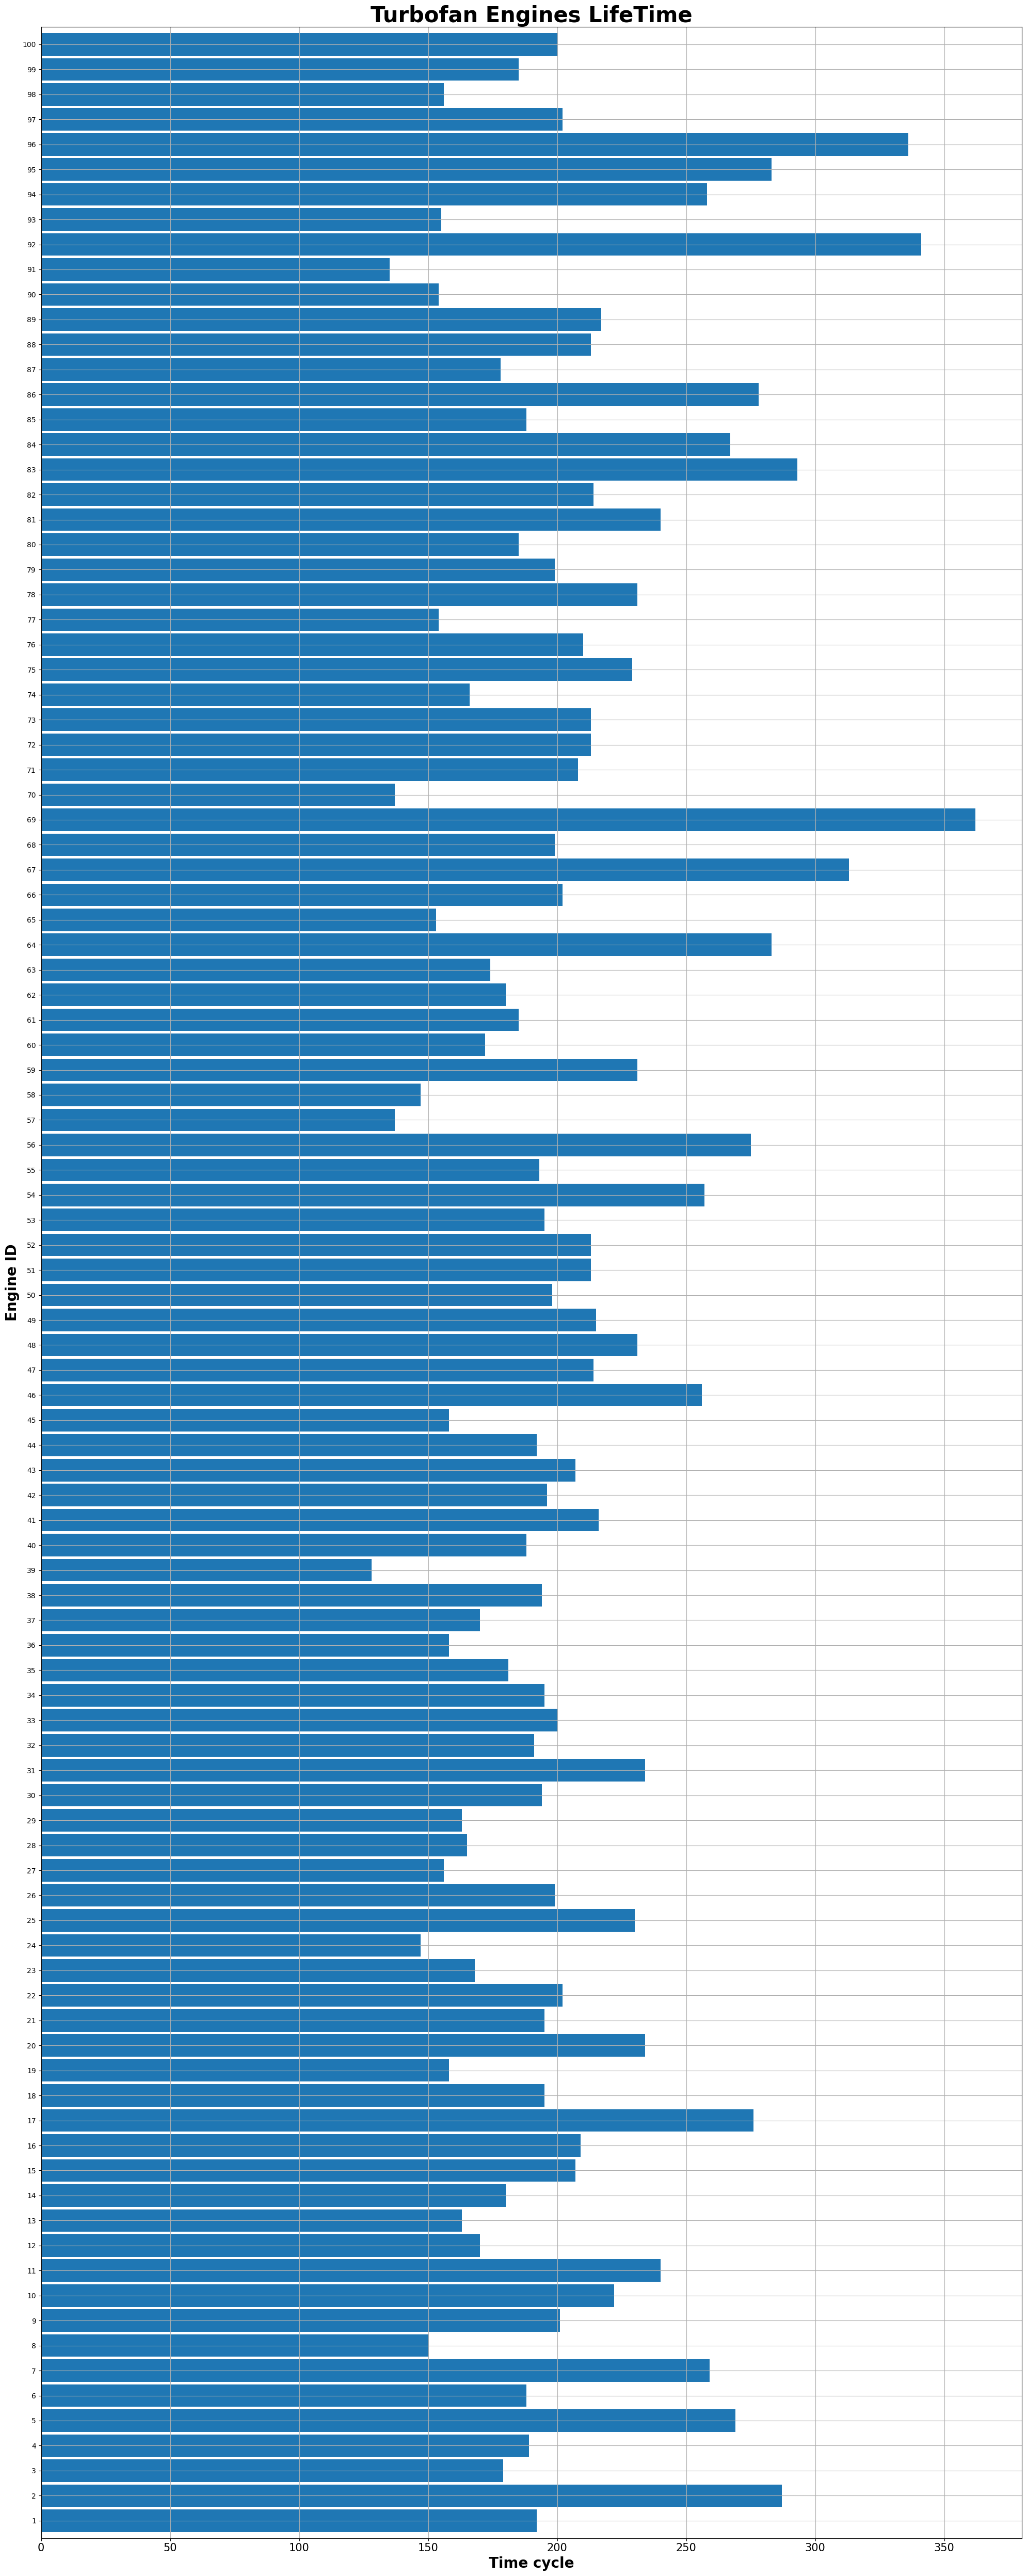

In [94]:
# Calculate the maximum time cycles for each engine
max_time_cycles = df_train_eda.groupby('engine_id')['time_in_cycles'].max()
# Plot the data
plt.figure(figsize=(20, 50))
ax = max_time_cycles.plot(kind='barh', width=0.9, stacked=True, align='center')
plt.title('Turbofan Engines LifeTime', fontweight='bold', size=30)
plt.xlabel('Time cycle', fontweight='bold', size=20)
plt.xticks(size=15)
plt.ylabel('Engine ID', fontweight='bold', size=20)
plt.yticks(size=10)
plt.grid(True)
plt.tight_layout()
plt.show()



 The primary goal is to understand how long each engine has been in operation by plotting the maximum time cycles for each engine. 
There are 100 turbofan engines , each having own lifespan. It will be interesting to see the minimum and maximum lifespan of given 100 engines,without specifying the engine id

In [95]:
#Check the max,min,average lifespan for the turbofan engines
df_train_eda['RUL'].describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

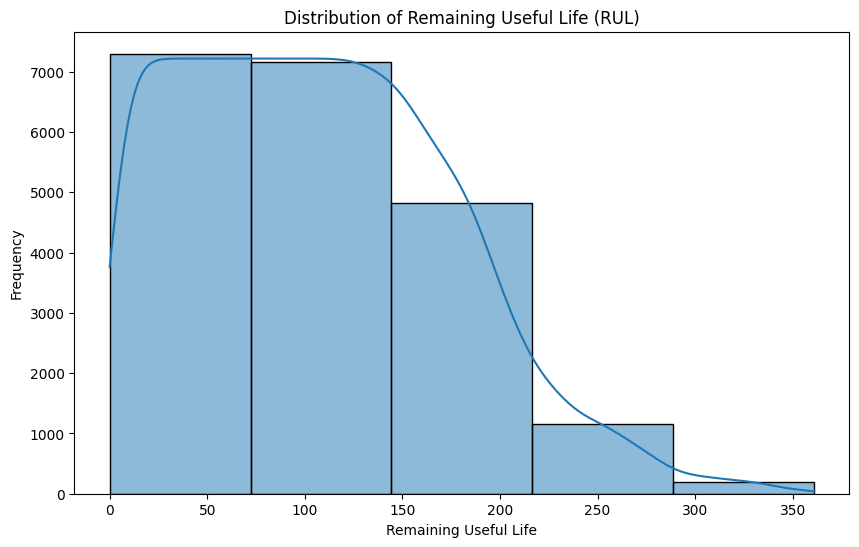

In [96]:
#Plotting the distribution of RUL values
plt.figure(figsize=(10, 6))
sns.histplot(df_train_eda['RUL'], bins=5, kde=True)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('Remaining Useful Life')
plt.ylabel('Frequency')
plt.show()

The RUL data is appears to be somewhat normally distributed around the mean, with a median close to the mean value. The presence of a maximum value of 361 cycles suggests there are outliers with significantly higher RUL compared to the rest of the dataset.


To observe how specific sensor reading change for multiple engines we can plot each sensor reading versus engine cycles

The main focus was to observe the connsistency of the sensor reading across several engine number.The engine to engine comparison of same sensor reading is good basis to observe same trend for several engines

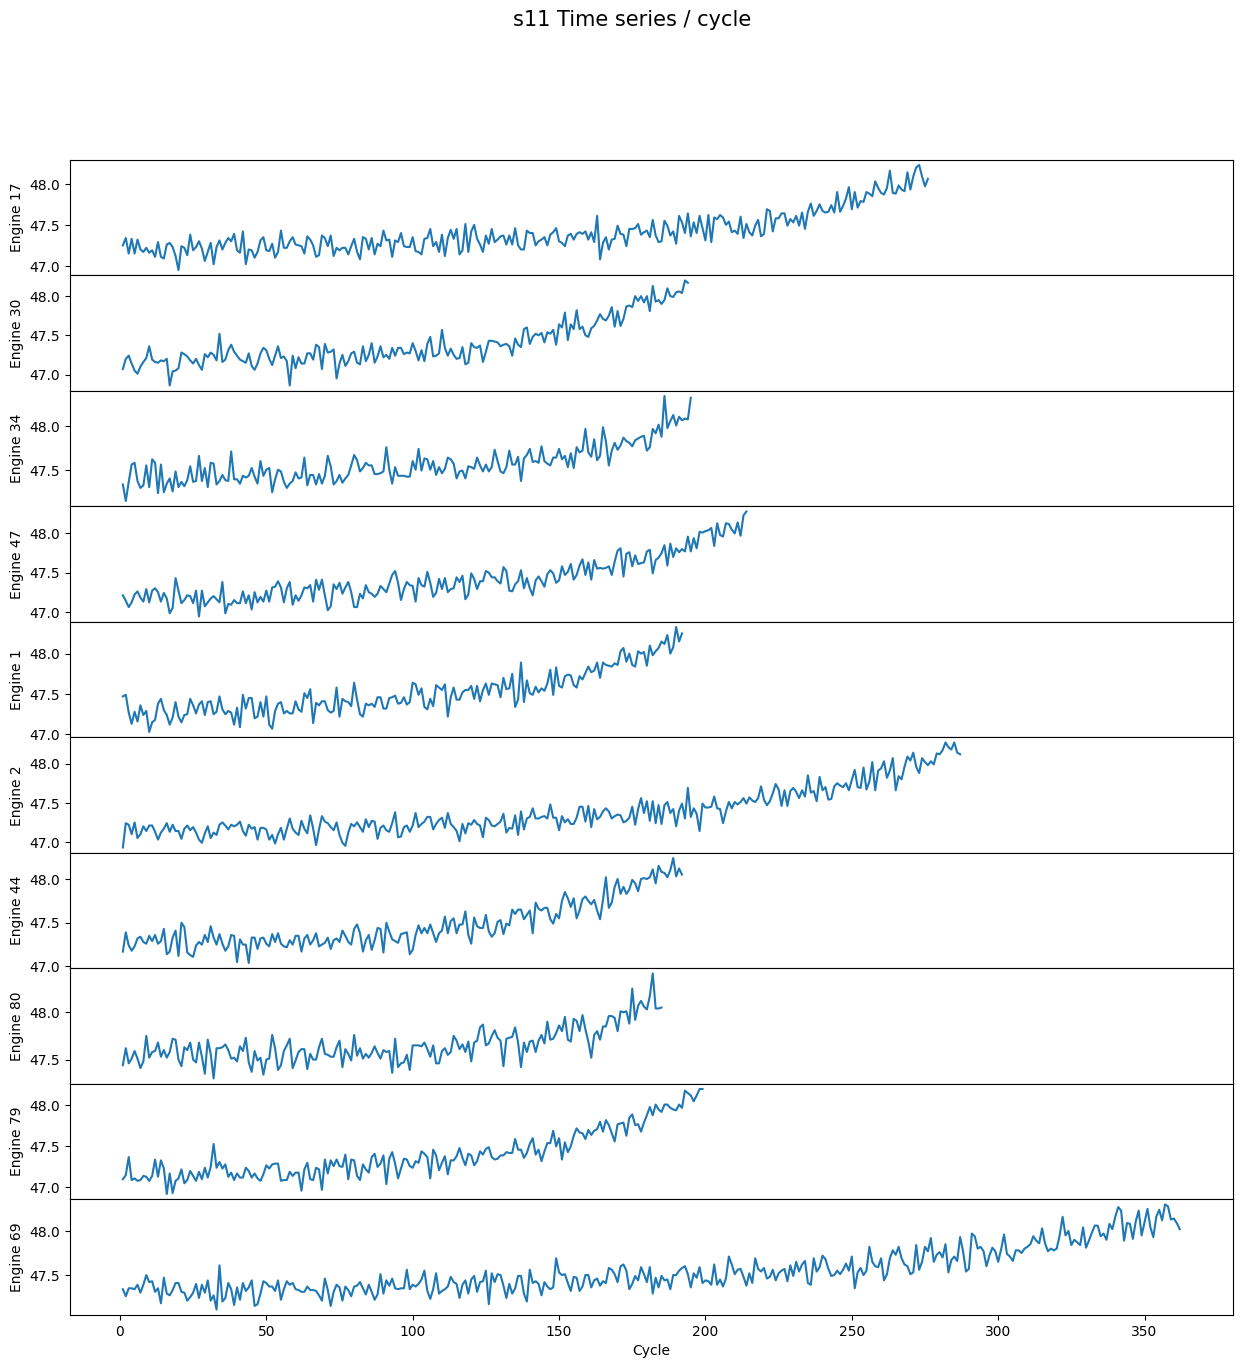

In [97]:
#Defining the function for the time series plot of sensor values
def plot_time_series(sensor):
    
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(15, 15))
    fig.suptitle(f'{sensor} Time series / cycle', fontsize=15)
    
    np.random.seed()  
    select_engines = np.random.choice(range(1, 101), 10, replace=False).tolist()
    
    for i, engine_id in enumerate(select_engines):
        df = df_train_eda[['time_in_cycles', sensor]][df_train_eda.engine_id == engine_id]
        axes[i].plot(df['time_in_cycles'], df[sensor])
        axes[i].set_ylabel('Engine ' + str(engine_id))
        axes[i].set_xlabel('Cycle')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    return select_engines

# Example usage
selected_engines = plot_time_series('s11')

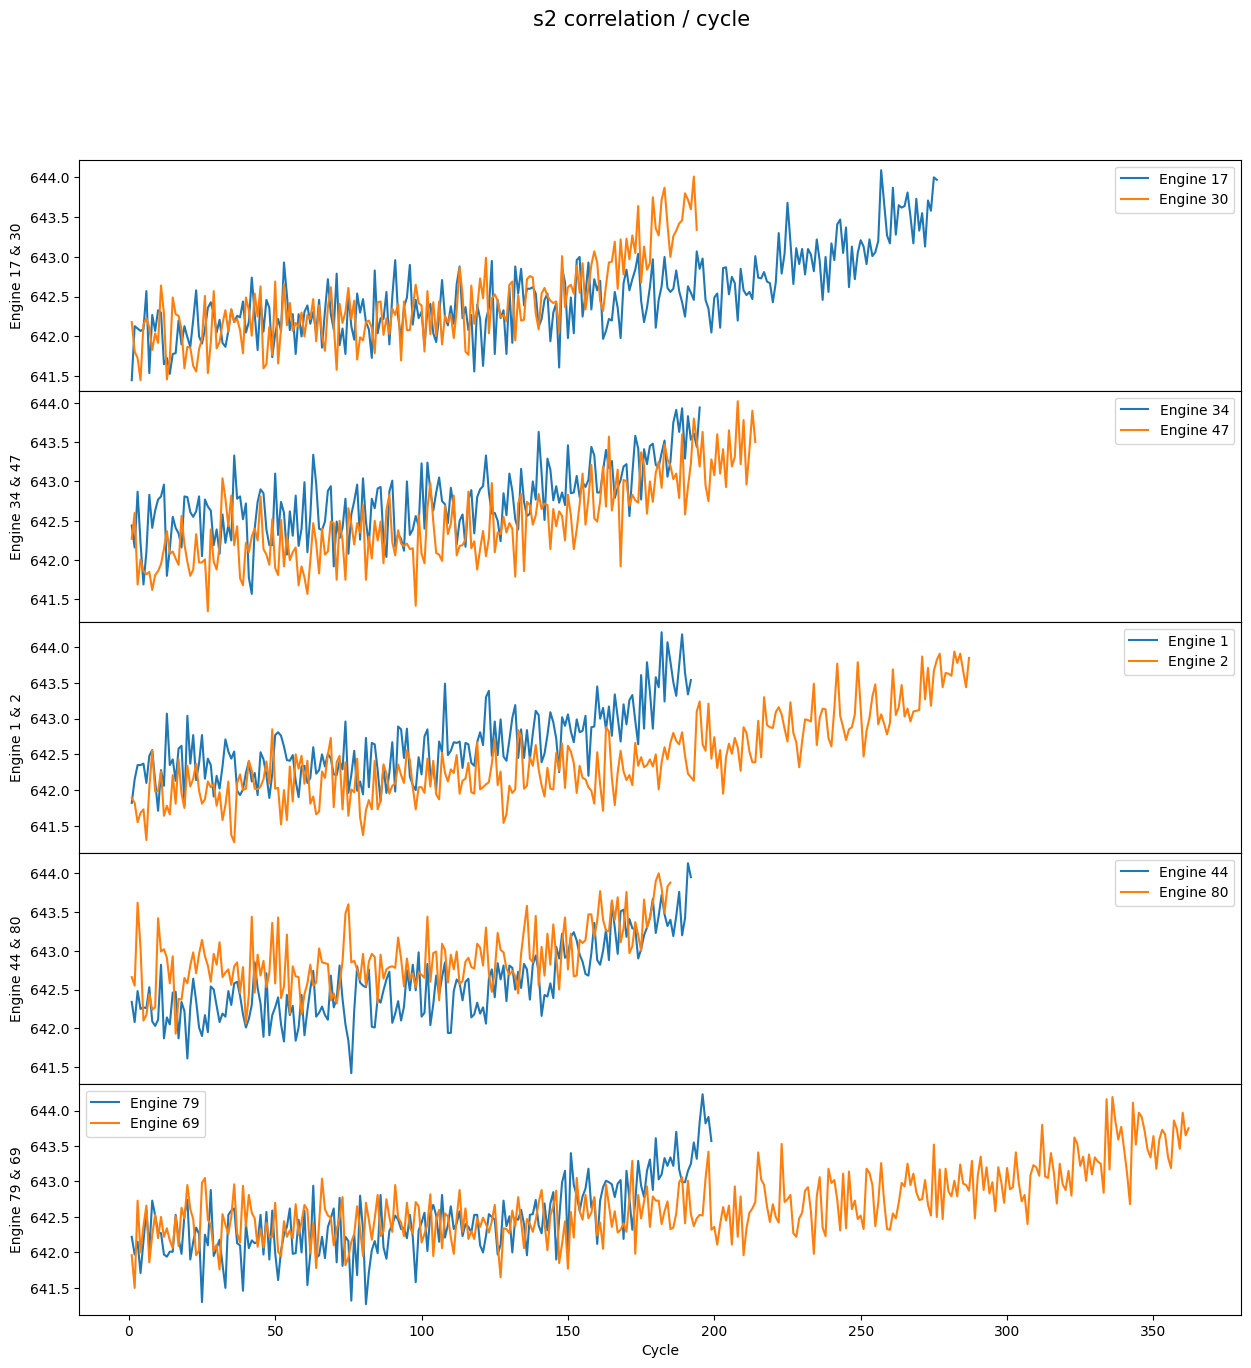

In [98]:

def plot_correlation(sensor, selected_engines):
    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(15, 15))
    fig.suptitle(f'{sensor} correlation / cycle', fontsize=15)
    
    correlations = []
    
    for i in range(5):
        engine_id1 = selected_engines[2 * i]
        engine_id2 = selected_engines[2 * i + 1]
        
        df1 = df_train_eda[['time_in_cycles', sensor]][df_train_eda.engine_id == engine_id1]
        df2 = df_train_eda[['time_in_cycles', sensor]][df_train_eda.engine_id == engine_id2]
        
        axes[i].plot(df1['time_in_cycles'], df1[sensor], label=f'Engine {engine_id1}')
        axes[i].plot(df2['time_in_cycles'], df2[sensor], label=f'Engine {engine_id2}')
        axes[i].set_ylabel(f'Engine {engine_id1} & {engine_id2}')
        axes[i].set_xlabel('Cycle')
        axes[i].legend()
        
        # Calculate correlation
        correlation = df1[sensor].corr(df2[sensor])
        correlations.append((engine_id1, engine_id2, correlation))
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

# Example usage
plot_correlation('s2', selected_engines)

In this step, we are visualizing the sensor data over the remaining useful life (RUL) of the engines. The goal is to understand how specific sensor readings change as the engines approach the end of their operational life.

In [99]:
#Creating the sensor dictionary
sensor_dictionary = {}
dict_list = [ 
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio(P50/P2)",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio) ",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]

skip_sensors = [1, 5,6, 10, 16, 18, 19]

i = 1
for x in dict_list:
    if i not in skip_sensors:
        sensor_dictionary['s' + str(i)] = x
    i += 1

sensor_dictionary

{'s2': '(LPC outlet temperature) (◦R)',
 's3': '(HPC outlet temperature) (◦R)',
 's4': '(LPT outlet temperature) (◦R)',
 's7': '(HPC outlet pressure) (psia)',
 's8': '(Physical fan speed) (rpm)',
 's9': '(Physical core speed) (rpm)',
 's11': '(HPC outlet Static pressure) (psia)',
 's12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's13': '(Corrected fan speed) (rpm)',
 's14': '(Corrected core speed) (rpm)',
 's15': '(Bypass Ratio) ',
 's17': '(Bleed Enthalpy)',
 's20': '(High-pressure turbines Cool air flow)',
 's21': '(Low-pressure turbines Cool air flow)'}

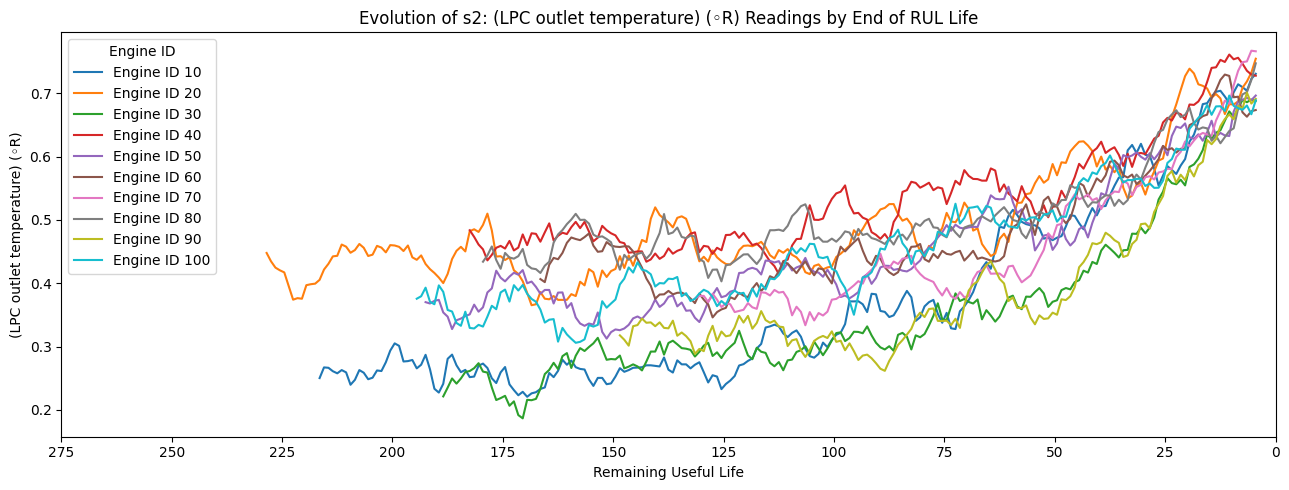

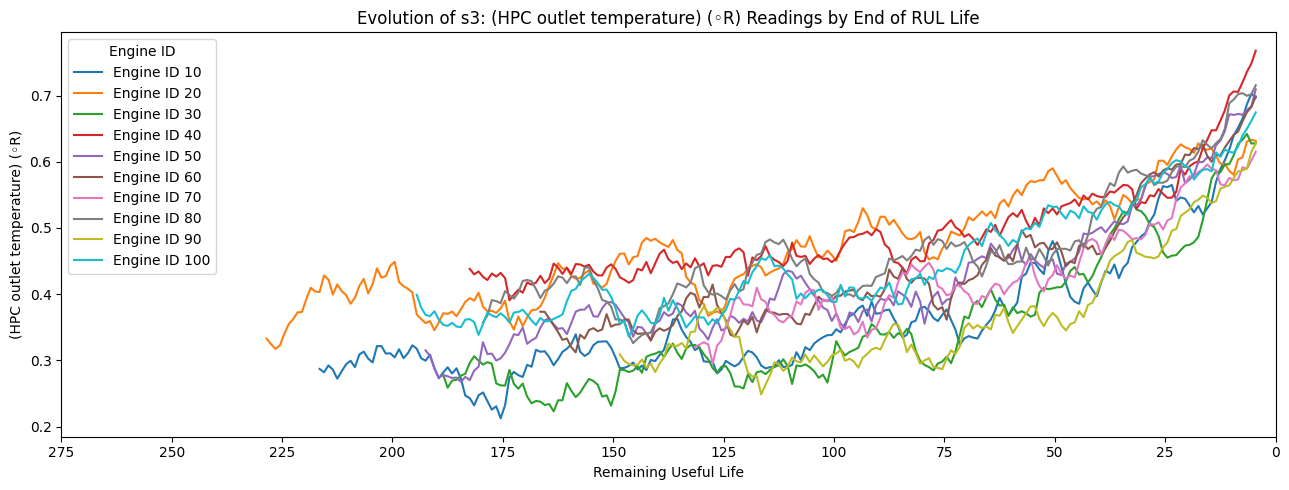

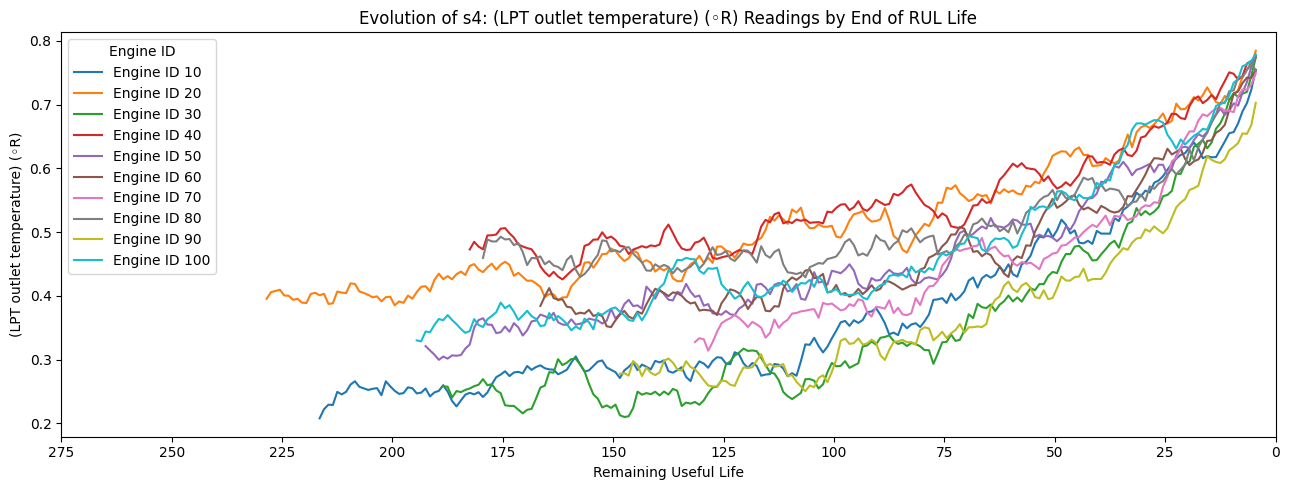

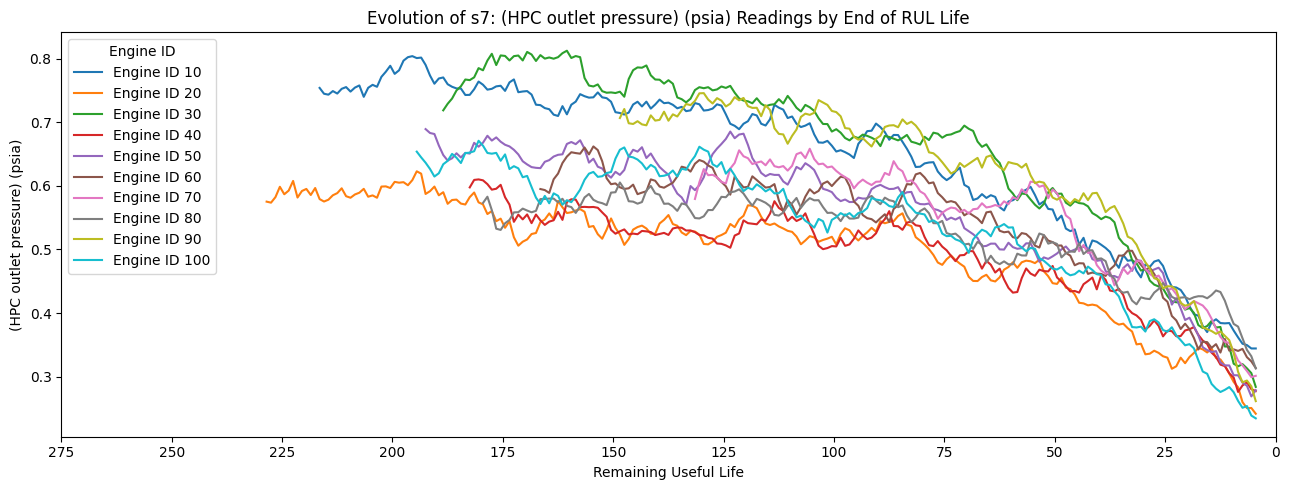

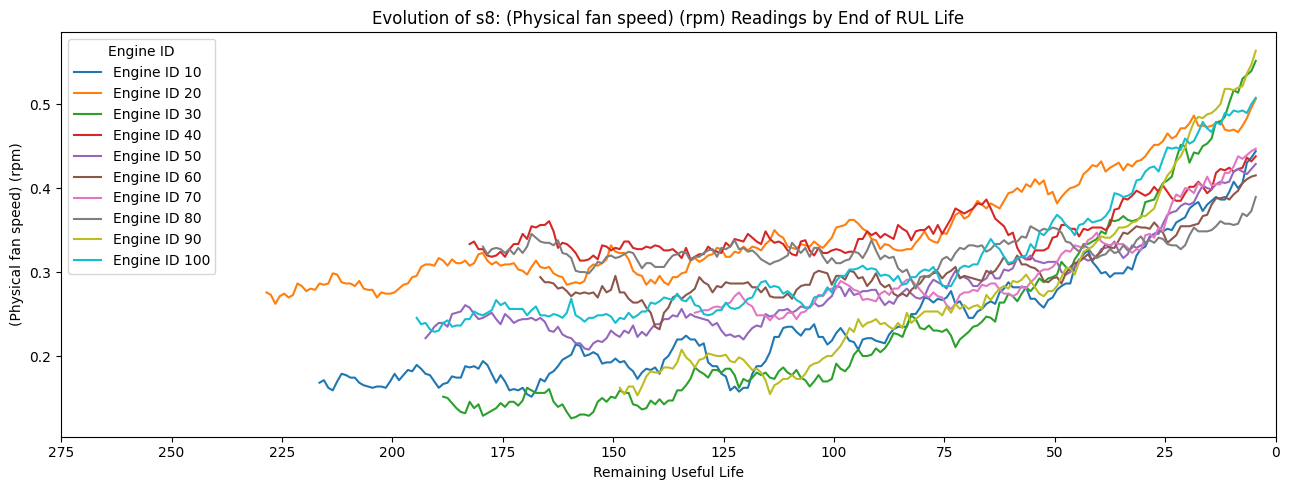

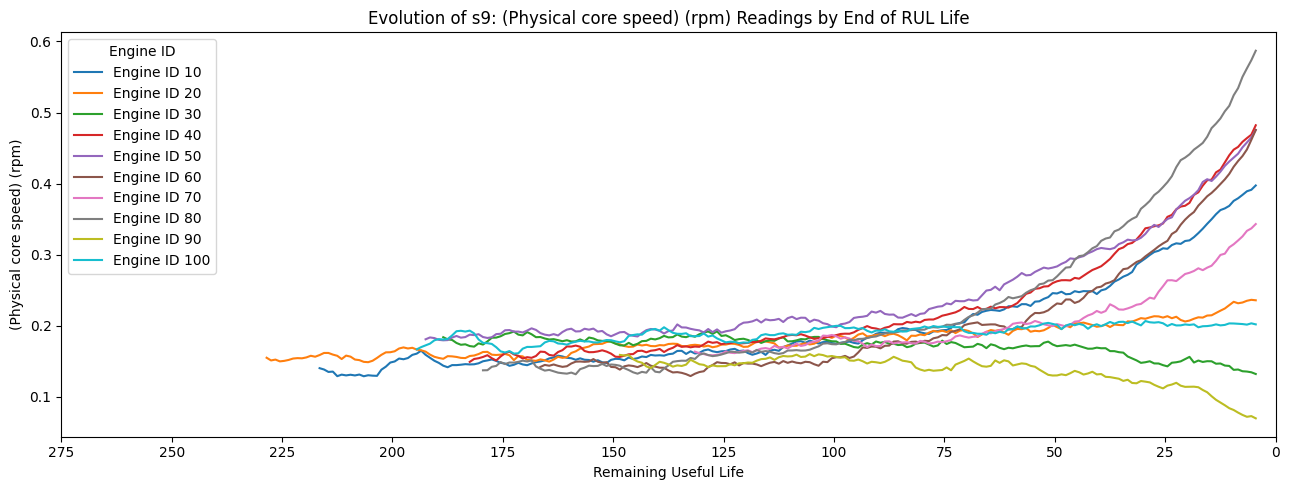

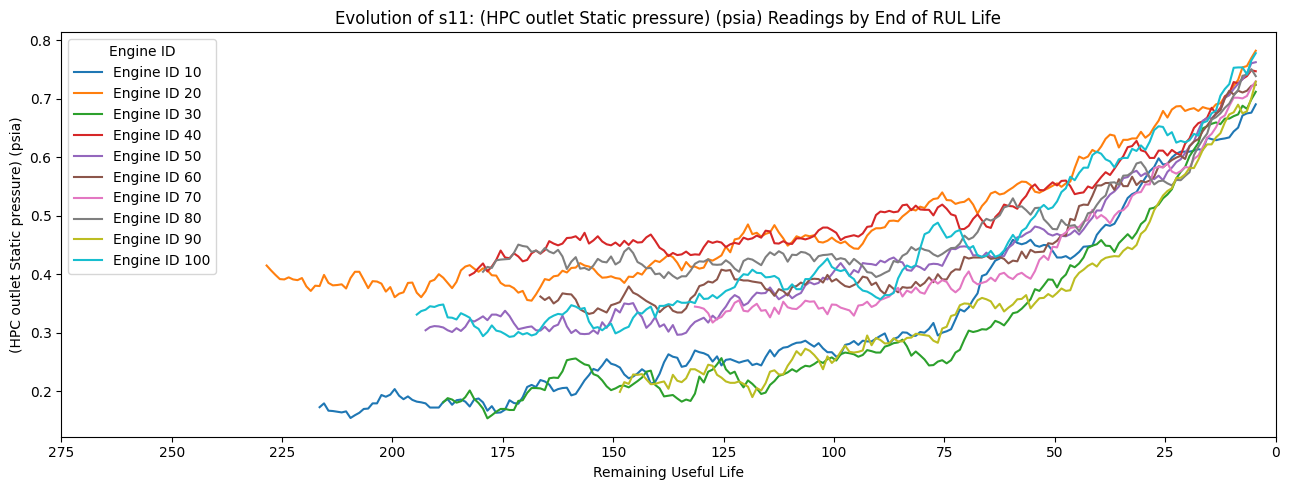

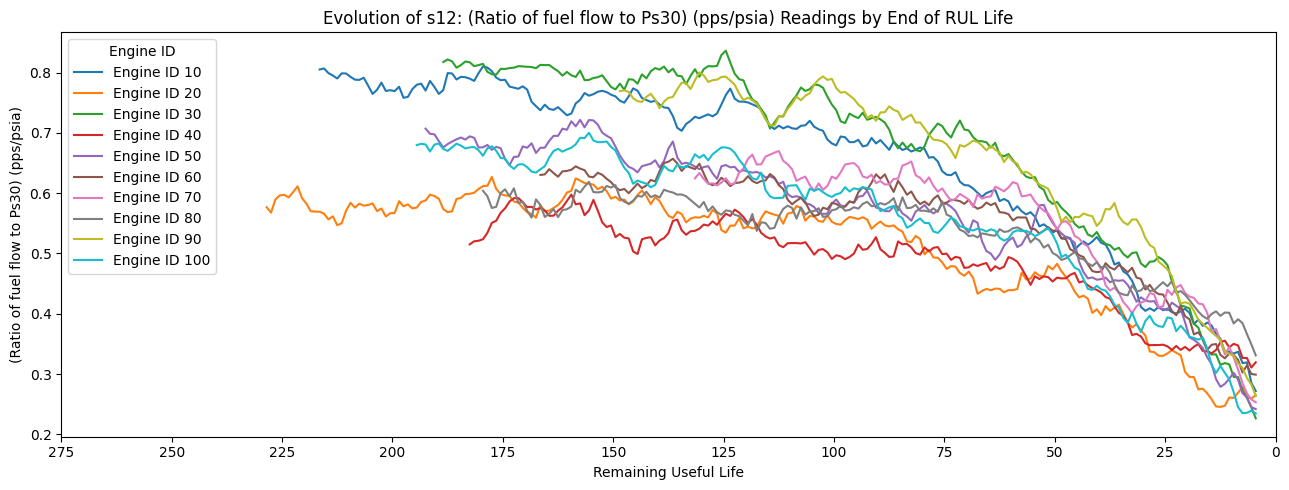

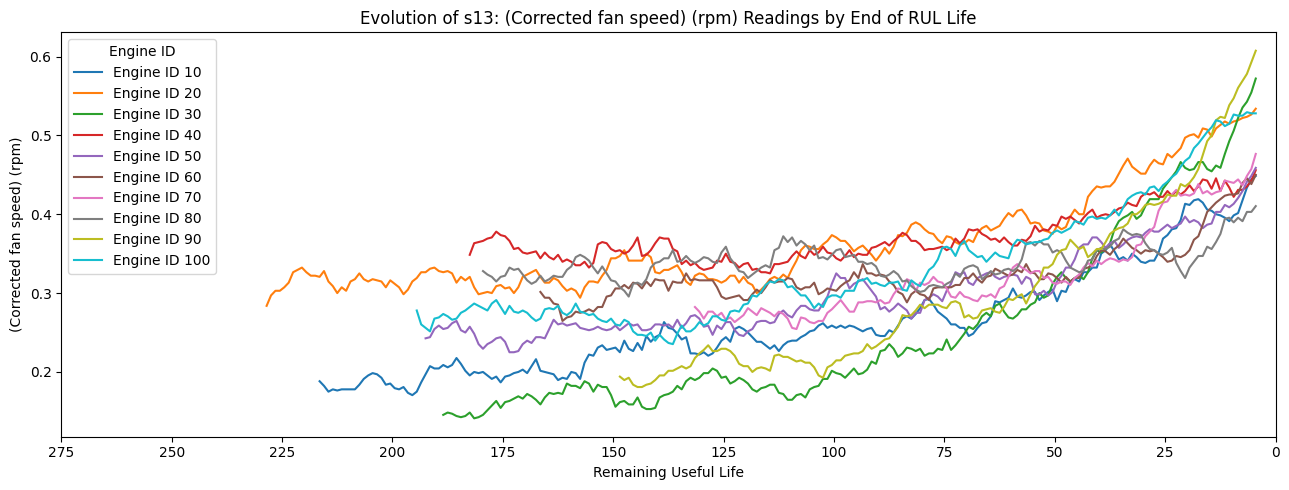

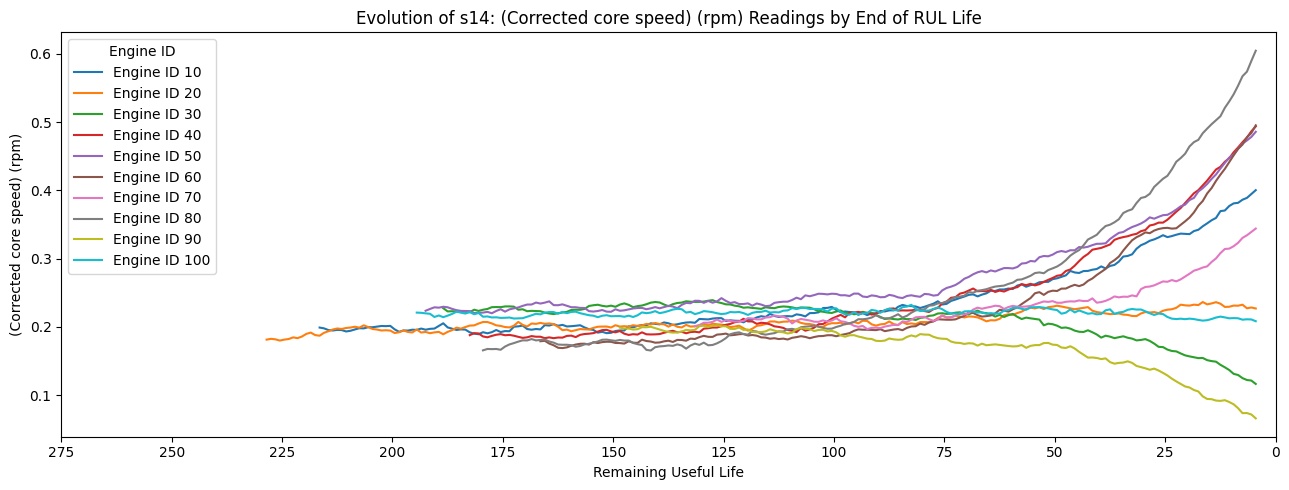

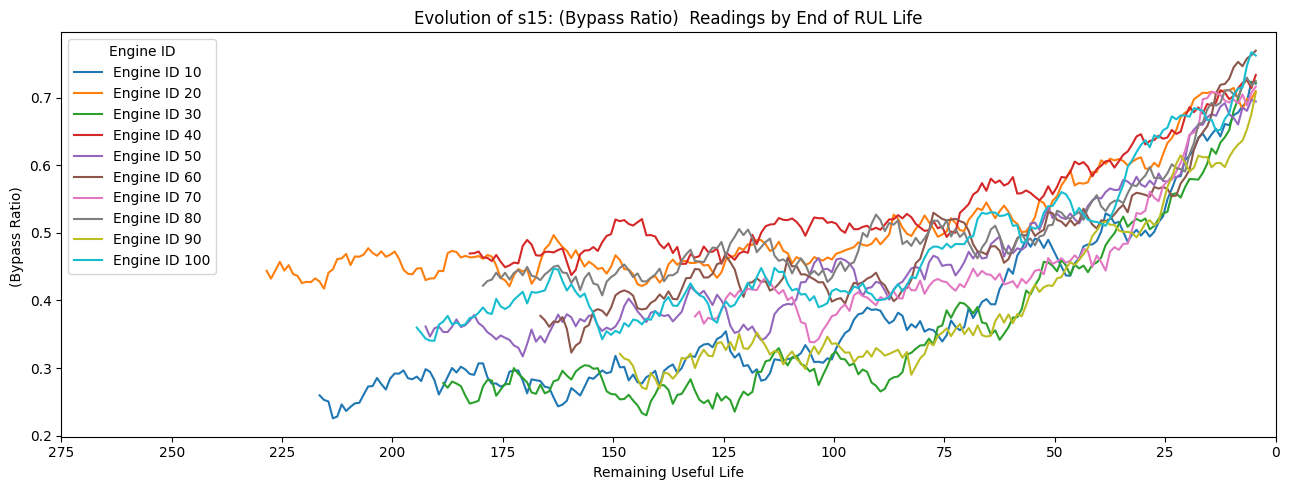

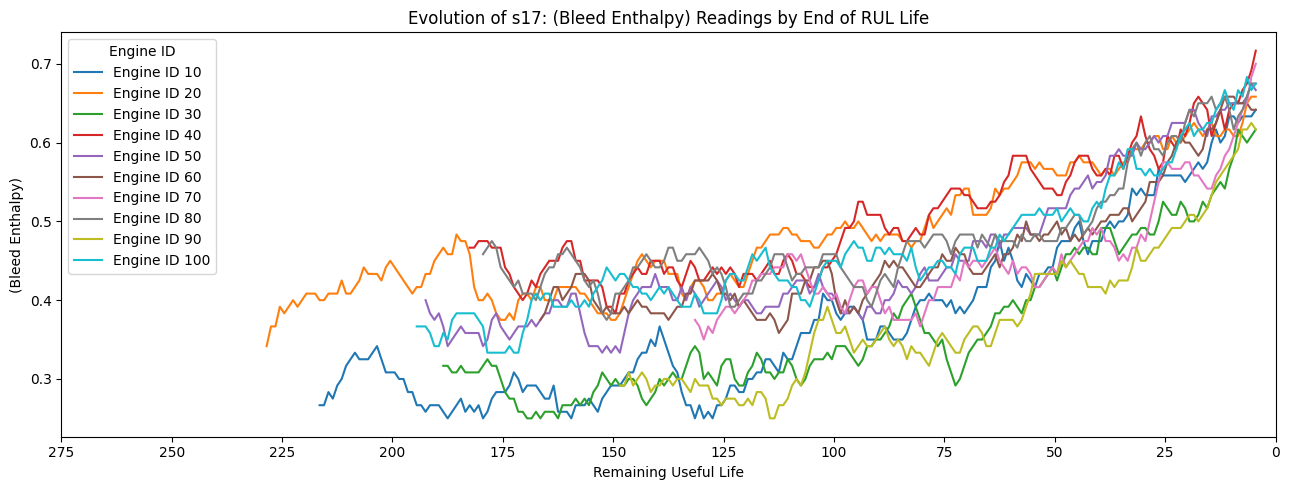

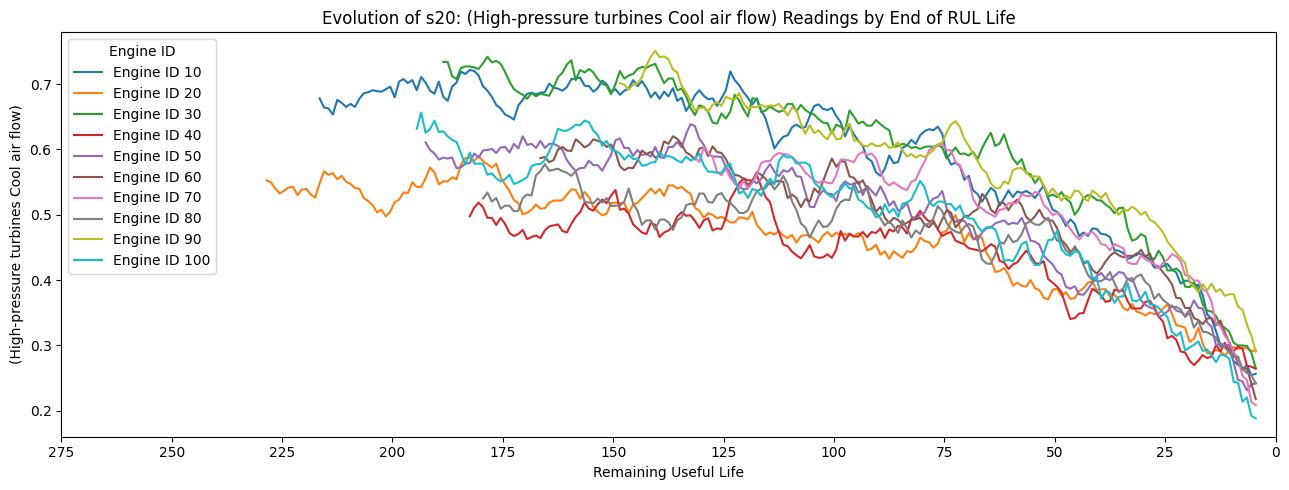

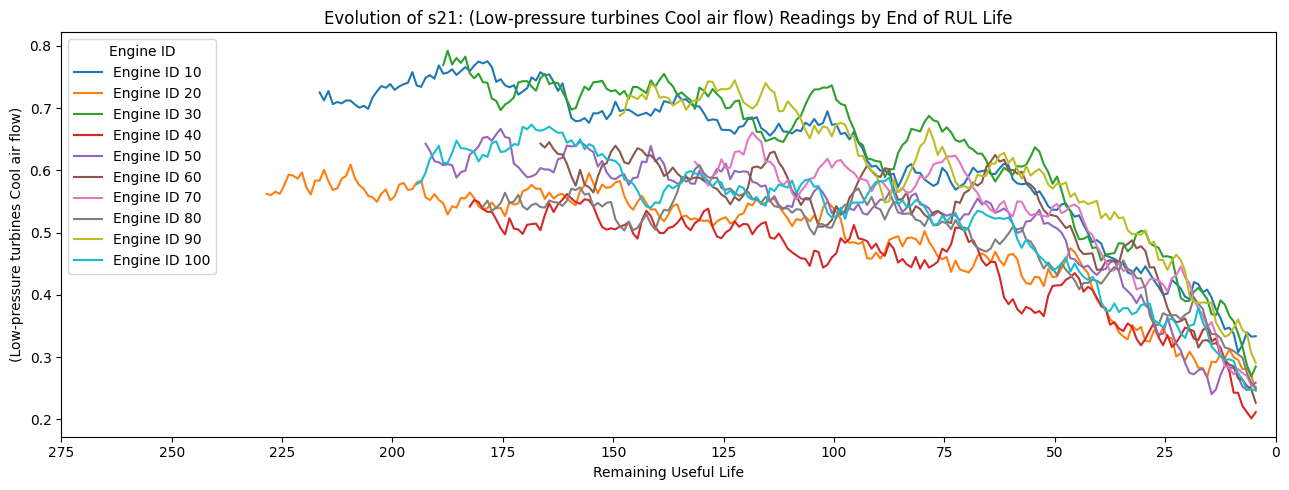

In [100]:
def plot_signal(df, sensor_dic, sensor_name):
    plt.figure(figsize=(13, 5))
    for i in df['engine_id'].unique():
        if (i % 10 == 0):  
            plt.plot(
                'RUL', sensor_name,
                data=df[df['engine_id'] == i].rolling(10).mean(),
                label=f'Engine ID {i}'
            )

    plt.xlim(250, 0) 
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(sensor_dic[sensor_name])
    plt.xlabel('Remaining Useful Life')
    plt.legend(title='Engine ID', loc='upper left') 
    plt.title(f'Evolution of {sensor_name}: {sensor_dic[sensor_name]} Readings by End of RUL Life')
    plt.tight_layout()  
    plt.show()
    plt.close() 

# Assuming df_train, sensor_dictionary, and skip_sensors are already defined
for i in range(1, 22):
    if i not in skip_sensors:
        try:
            plot_signal(df_train_fe_dc, sensor_dictionary, 's' + str(i))
        except KeyError:
            pass

Obviously, for engines, degradation is indicated by an increase in some sensor readings and a decrease in others.For example, the LPC outlet temperature (s2) tends to increase ,which is sign of obvious degradation, due to end of useful life.

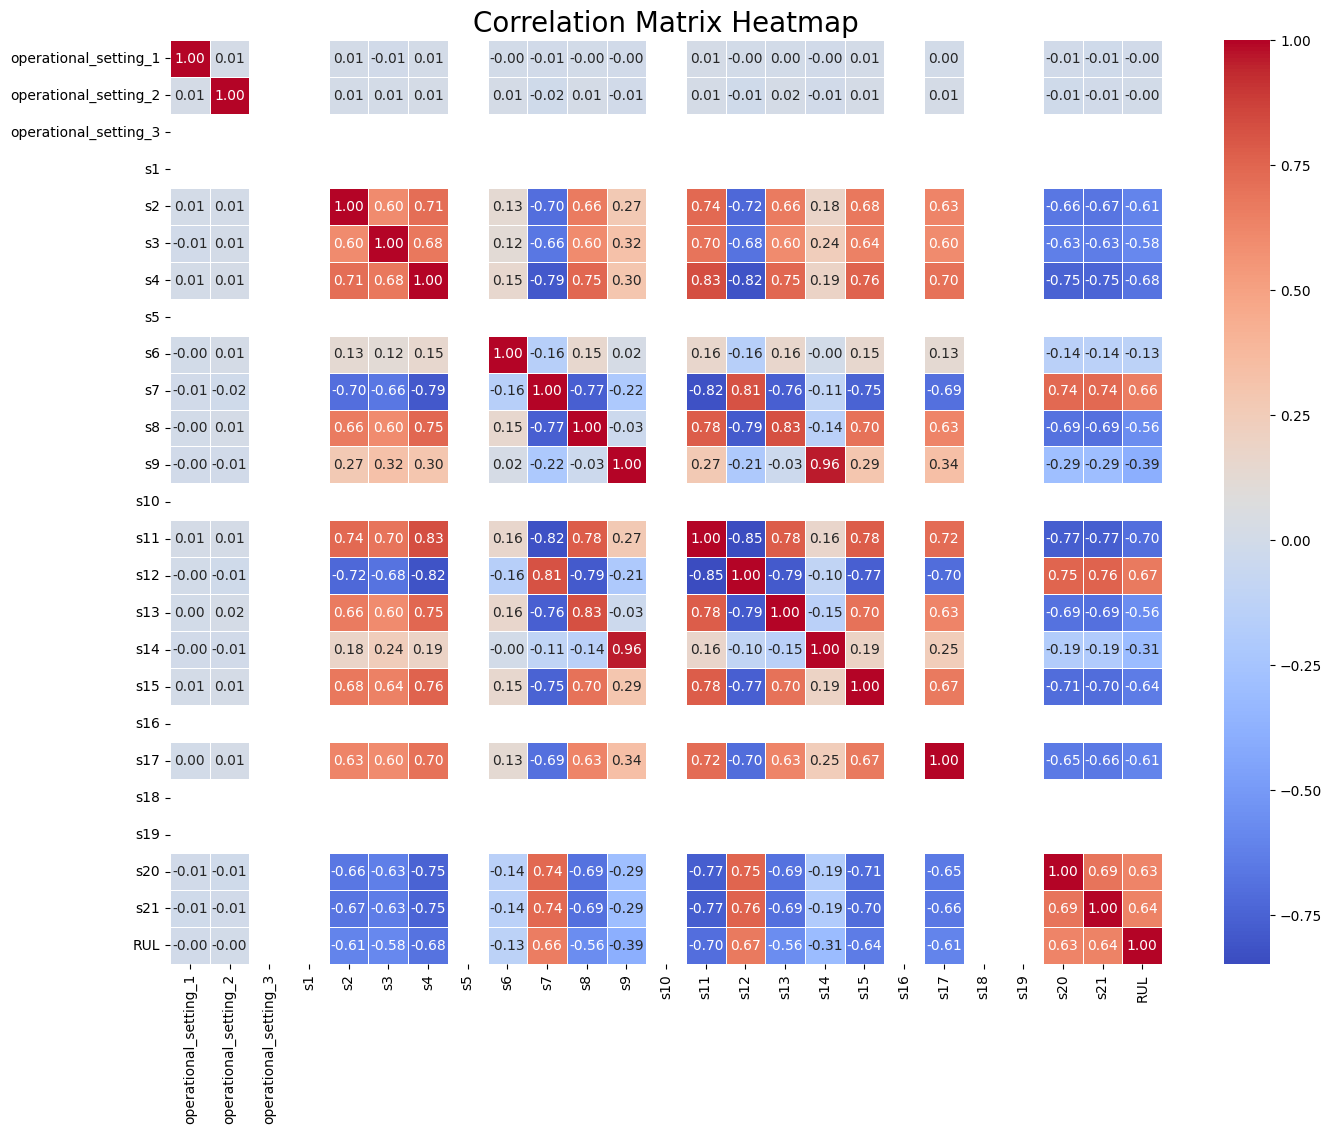

In [101]:

df_train_corr = df_train_eda.drop(columns=['engine_id', 'time_in_cycles',])
corr_matrix = df_train_corr.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.show()

There is a very high correlation (> 0.8) between some features e.g.(s14 & s9), (s11 & s4), (s11 & s7), (s11 & s12), (s4 & s12), (s8 & s13), (s7 & s12). This multicollinearity may hurt the performance of some machine learning algorithms. So, part of these features will be target for elimination in feature selection during the modeling phase.

## Modelling

In [102]:
#Define the evaluate function to evaluate metrics
def evaluate(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred) 
    print(f"Evaluation for {label}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R^2 Score: {r2:.4f}")

First we try to predict RUL with regressor method, because the prediction of remaining useful life based of given operational settings and sensor readings is good candidate of regression problem solving.

During feature optimization,it has been observed that, simple normalization do no produce good metrics. That is why another type of normalization was proposed. In the modelling section, we will check the result after each normalization procedure. The model was choosen as the Light GMB and extensive parameter optimization was conducted by Grid Search Optimization Method.

At the modelling part , we will test 4 datasets
- df_train_fe_dc , df_train_fe_dc - The operational columns has been removed and sensors columns have been normalized with the min-max normalization
- df_train_fe_nr_n , df_valid_fe_nr_n - The operational columns have been removed and sensors columns have been normalized by first 10 values


# Simply Normalized Dataset

#### Predictions on the train datasets

In [103]:
#Splitting the dataset into train and test sets
X=df_train_fe_dc.drop(columns=['engine_id','RUL'])
y=df_train_fe_dc['RUL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

#Grid Search for hyperparameter tuning
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'verbose': [-1]
}
# Create the LGBMRegressor model
lgbm_model_with_gs = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the model to the training data
lgbm_model_with_gs.fit(X_train, y_train)
joblib.dump(lgbm_model_with_gs, 'lgbm_model_with_gs.joblib')


"\n#Grid Search for hyperparameter tuning\n# Define the parameter grid for hyperparameter tuning\nparam_grid = {\n    'num_leaves': [100, 200, 300],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'n_estimators': [50, 100, 150],\n    'max_depth': [5, 10, 15],\n    'verbose': [-1]\n}\n# Create the LGBMRegressor model\nlgbm_model_with_gs = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)\n\n# Fit the model to the training data\nlgbm_model_with_gs.fit(X_train, y_train)\njoblib.dump(lgbm_model_with_gs, 'lgbm_model_with_gs.joblib')\n"

In [120]:
#Load the model and make predictions
import lightgbm as lgb
loaded_model_lgbm_model_with_gs = joblib.load('lgbm_model_with_gs.joblib')
best_params= loaded_model_lgbm_model_with_gs.best_params_
best_model_lgbm_model_with_gs = lgb.LGBMRegressor(**best_params)
best_model_lgbm_model_with_gs.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgbm_model_with_gs= best_model_lgbm_model_with_gs.predict(X_test)
evaluate(y_test, y_pred_lgbm_model_with_gs, label='test')

Evaluation for test:
  Mean Absolute Error (MAE): 8.4362
  Mean Squared Error (MSE): 149.7443
  Root Mean Squared Error (RMSE): 12.2370
  R^2 Score: 0.9053


#### Prediction on the validation dataset

In [121]:
X_valid_1=df_valid_fe_dc.groupby('engine_id').last().reset_index()
X_valid_1=X_valid_1.drop(columns='engine_id')
y_valid_1=y_valid['RUL']

In [122]:
#Make prediction on the validation dataset
y_pred_lgbm_model_with_gs_valid= best_model_lgbm_model_with_gs.predict(X_valid_1)    
evaluate(y_valid_1, y_pred_lgbm_model_with_gs_valid, label='valid')

Evaluation for valid:
  Mean Absolute Error (MAE): 41.2156
  Mean Squared Error (MSE): 2781.6549
  Root Mean Squared Error (RMSE): 52.7414
  R^2 Score: -0.6108


In [123]:
# Calculate the bias
bias = y_pred_lgbm_model_with_gs_valid.mean() - y_valid_1.mean()
print(f"Bias: {bias}")

Bias: 27.510111029116857


The metrics are high for train dataset but very low for validation dataset. That is clear indication of overfitting.The model performs high on the test dataset and poor on validation dataset. The reasons could be poor feature optimization,which will be discussed on the next section

# Dataset normalized with n-values

#### Prediction on the test dataset

In [124]:
X=df_train_fe_nr_n.drop(columns=setting_names+drop_labels+['RUL']+['engine_id'])
y=df_train_fe_nr_n['RUL']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)


In [ ]:

#   Grid Search for hyperparameter tuning
#   Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'verbose': [-1]
}
#   Create the LGBMRegressor model
lgbm_model_with_gs_nr_nc = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

#   Fit the model to the training data
lgbm_model_with_gs_nr_nc.fit(X_train, y_train)
joblib.dump(lgbm_model_with_gs_nr_nc, 'lgbm_model_with_gs_nr_nc.joblib')



"\n#Grid Search for hyperparameter tuning\n# Define the parameter grid for hyperparameter tuning\nparam_grid = {\n    'num_leaves': [100, 200, 300],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'n_estimators': [50, 100, 150],\n    'max_depth': [5, 10, 15],\n    'verbose': [-1]\n}\n#   Create the LGBMRegressor model\nlgbm_model_with_gs_nr_nc = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)\n\n#   Fit the model to the training data\nlgbm_model_with_gs_nr_nc.fit(X_train, y_train)\njoblib.dump(lgbm_model_with_gs_nr_nc, 'lgbm_model_with_gs_nr_nc.joblib')\n\n"

In [125]:
import lightgbm as lgb
loaded_model_lgbm_model_with_gs_nr_nc = joblib.load('lgbm_model_with_gs_nr_nc.joblib')
best_params= loaded_model_lgbm_model_with_gs_nr_nc.best_params_
best_model_lgbm_model_with_gs_nr_nc = lgb.LGBMRegressor(**best_params)
best_model_lgbm_model_with_gs_nr_nc.fit(X_train, y_train)
y_pred_lgbm_model_with_gs_nr_nc= best_model_lgbm_model_with_gs_nr_nc.predict(X_test)
evaluate(y_test, y_pred_lgbm_model_with_gs_nr_nc, label='test')

Evaluation for test:
  Mean Absolute Error (MAE): 7.5459
  Mean Squared Error (MSE): 127.1033
  Root Mean Squared Error (RMSE): 11.2740
  R^2 Score: 0.9196


### With n-value-normalized validation dataset

In [126]:
X_valid_2=df_valid_fe_nr_n.groupby('engine_id').last().reset_index().drop(columns=setting_names+drop_labels+['engine_id'])   
y_valid_2=y_valid['RUL']

In [127]:
y_pred_lgbm_model_with_gs_nr_nc_valid_1= best_model_lgbm_model_with_gs_nr_nc.predict(X_valid_2)    
evaluate(y_valid_2, y_pred_lgbm_model_with_gs_nr_nc_valid_1, label='valid')

Evaluation for valid:
  Mean Absolute Error (MAE): 11.1428
  Mean Squared Error (MSE): 233.4545
  Root Mean Squared Error (RMSE): 15.2792
  R^2 Score: 0.8648


In [128]:
# Calculate the bias
bias = y_pred_lgbm_model_with_gs_nr_nc_valid_1.mean() - y_valid_3.mean()
print(f"Bias: {bias}")

Bias: -3.0595407383150075


# Clipped and Simply Normalized Dataset

In [129]:
X_c=clipping(df_train_fe_dc,['RUL'],121)
X=X_c.drop(columns=['engine_id','RUL'])
y=X_c['RUL']

#### Prediction on the train dataset

In [130]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)

In [ ]:

# Grid Search for Hyperparameter Tuning
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'verbose': [-1]
}

#  Create the LGBMRegressor model
lgbm_model_with_gs_c = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

#  Fit the model to the training data
lgbm_model_with_gs_c.fit(X_train, y_train)
joblib.dump(lgbm_model_with_gs_c, 'lgbm_model_with_gs_c.joblib')



"\n# Grid Search for Hyperparameter Tuning\n# Define the parameter grid for hyperparameter tuning\nparam_grid = {\n    'num_leaves': [100, 200, 300],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'n_estimators': [50, 100, 150],\n    'max_depth': [5, 10, 15],\n    'verbose': [-1]\n}\n\n#  Create the LGBMRegressor model\nlgbm_model_with_gs_c = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)\n\n#  Fit the model to the training data\nlgbm_model_with_gs_c.fit(X_train, y_train)\njoblib.dump(lgbm_model_with_gs_c, 'lgbm_model_with_gs_c.joblib')\n"

In [131]:
# Load the model and make predictions
loaded_model_lgbm_model_with_gs_c = joblib.load('lgbm_model_with_gs_c.joblib')
best_params= loaded_model_lgbm_model_with_gs_c.best_params_
best_model_lgbm_model_with_gs_c = lgb.LGBMRegressor(**best_params)
best_model_lgbm_model_with_gs_c.fit(X_train, y_train)
y_pred_lgbm_model_with_gs_c= best_model_lgbm_model_with_gs_c.predict(X_test)
evaluate(y_test, y_pred_lgbm_model_with_gs_c, label='test')

Evaluation for test:
  Mean Absolute Error (MAE): 10.1290
  Mean Squared Error (MSE): 234.1432
  Root Mean Squared Error (RMSE): 15.3017
  R^2 Score: 0.8519


###  Simple normalized 

In [132]:
# Make predictions on the validation dataset
y_pred_lgbm_model_with_gs_c= best_model_lgbm_model_with_gs_c.predict(X_valid_1)    
evaluate(y_valid_1, y_pred_lgbm_model_with_gs_c, label='valid')

Evaluation for valid:
  Mean Absolute Error (MAE): 30.2236
  Mean Squared Error (MSE): 1373.8642
  Root Mean Squared Error (RMSE): 37.0657
  R^2 Score: 0.2044


In [133]:
bias = y_pred_lgbm_model_with_gs_c.mean() - y_valid_1.mean()
print(f"Bias: {bias}")

Bias: -29.14276911753656


# Clipped and N-normalized dataset

In [134]:
# Clipping the RUL values above the certain threshold
df_train_fe_nr_n_c=clipping(df_train_fe_nr_n,['RUL'],121)
X=df_train_fe_nr_n_c.drop(columns=setting_names+drop_labels+['RUL']+['engine_id'])
y=df_train_fe_nr_n_c['RUL']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)


In [65]:
# Grid Search for Hyperparameter Tuning
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'verbose': [-1]
}

#  Create the LGBMRegressor model
lgbm_model_with_gs_nr_c = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

#  Fit the model to the training data
lgbm_model_with_gs_nr_c.fit(X_train, y_train)

joblib.dump(lgbm_model_with_gs_nr_c, 'lgbm_model_with_gs_nr_c.pkl')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


['lgbm_model_with_gs_nr_c.pkl']

In [135]:
# Load the model and make predictions
loaded_model_lgbm_model_with_gs_nr_c = joblib.load('lgbm_model_with_gs_nr_c.pkl')
best_params= loaded_model_lgbm_model_with_gs_nr_c.best_params_
best_model_lgbm_model_with_gs_nr_c = lgb.LGBMRegressor(**best_params)
best_model_lgbm_model_with_gs_nr_c.fit(X_train, y_train)
y_pred_lgbm_model_with_gs_nr_c= best_model_lgbm_model_with_gs_nr_c.predict(X_test)
evaluate(y_test, y_pred_lgbm_model_with_gs_nr_c, label='test')


Evaluation for test:
  Mean Absolute Error (MAE): 7.5459
  Mean Squared Error (MSE): 127.1033
  Root Mean Squared Error (RMSE): 11.2740
  R^2 Score: 0.9196


In [136]:
y_pred_lgbm_model_with_gs_nr_c_valid= best_model_lgbm_model_with_gs_nr_c.predict(X_valid_2)    
evaluate(y_valid_2, y_pred_lgbm_model_with_gs_nr_nc_valid_1, label='valid')

Evaluation for valid:
  Mean Absolute Error (MAE): 11.1428
  Mean Squared Error (MSE): 233.4545
  Root Mean Squared Error (RMSE): 15.2792
  R^2 Score: 0.8648


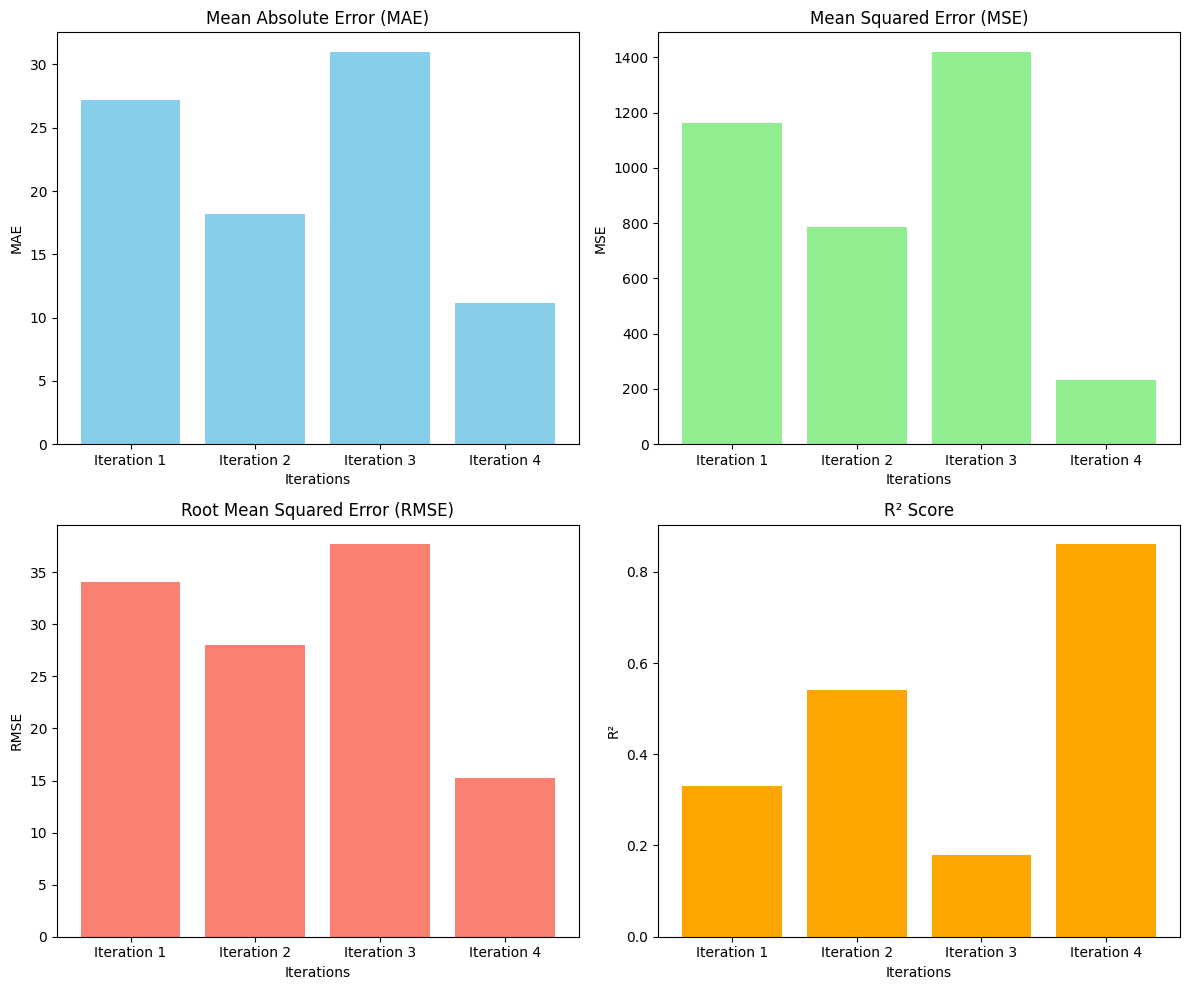

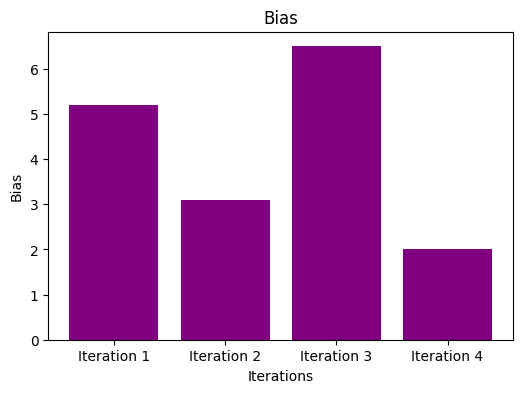

In [137]:


# Example data (replace with your actual data)
iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4']
mae = [27.19, 18.20, 30.99, 11.14]
mse = [1163.37, 786.76, 1419.32, 233.45]
rmse = [34.11, 28.05, 37.67, 15.28]
r2 = [0.33, 0.54, 0.18, 0.86]
bias = [5.2, 3.1, 6.5, 2.0]  # Example bias values

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MAE Plot
axes[0, 0].bar(iterations, mae, color='skyblue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_xlabel('Iterations')

# MSE Plot
axes[0, 1].bar(iterations, mse, color='lightgreen')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].set_xlabel('Iterations')

# RMSE Plot
axes[1, 0].bar(iterations, rmse, color='salmon')
axes[1, 0].set_title('Root Mean Squared Error (RMSE)')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_xlabel('Iterations')

# R² Plot
axes[1, 1].bar(iterations, r2, color='orange')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_xlabel('Iterations')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Optional: Add Bias Graph Separately
plt.figure(figsize=(6, 4))
plt.bar(iterations, bias, color='purple')
plt.title('Bias')
plt.ylabel('Bias')
plt.xlabel('Iterations')
plt.show()

As mentioned in the feature optimization section, the clipping and normalization with first ten values lead to great result at the prediction of RUL values.